# CBA 2020
## Detecção de anomalias em poços produtores de petróleo usando aprendizado de máquina

**_Principais Referências_**
  
- **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** ([link](https://doi.org/10.1016/j.petrol.2019.106223)).
- **Github de referência do _benchmark_ proposto por Vargas (2019)** ([link](https://github.com/ricardovvargas/3w_dataset)).

## 1. Regras do benchmark proposto por Vargas (2019)

- Apenas instâncias reais com anomalias de tipos que têm períodos normais maiores ou iguais a vinte minutos foram utilizadas;

- Múltiplas rodadas de treinamento e validação realizadas, sendo o número de rodadas igual ao número de instâncias. Em cada rodada, amostras utilizadas para treinamento ou validação extraídas de apenas uma instância. Parte das amostras de normalidade utilizadas no treinamento e a outra parte na validação. Todas as amostras de anomalias devem ser utilizadas apenas na validação, sendo, portanto, uma técnica de aprendizagem de classe única. O conjunto de validação deve ser composto pelo mesmo número de amostras de cada classe (normalidade e anormalidade);

- Em cada rodada, precisão, revogação e medida F1 devem ser computadas (valor médio e desvio padrão de cada métrica), sendo o valor médio da medida F1 considerado a principal métrica de desempenho.

## 1.1 Outras definições adotadas

- Uma estratégia de amostragem específica com janela deslizante foi usada para cada tipo de período. Em períodos normais, as primeiras observações são usadas para treinamento e as últimas são usadas para testes. Em períodos transientes, procura-se usar observações como um todo (apenas para teste). Em períodos de regime, as primeiras observações são privilegiadas (somente para teste);

- Antes de cada rodada de treinamento e teste:
    - As amostras utilizadas (não as instâncias) são adequadamente normalizadas com o z-score;
    - As variáveis de amostras (não as instâncias) usadas para treinamento que possuem um número de NaNs acima de um limite ou que têm um desvio padrão abaixo de um outro limite são descartadas.

- Todos os random_state necessários são atribuídos a uma constante para que os resultados sejam reproduzíveis.

## 2. Bibliotecas e configurações

In [1]:
# Artifício para alcular tempo total do notebook Jupyter
from datetime import datetime 
start_time = datetime.now()

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import logging
import warnings
import sys
sys.path.append('stac')
import nonparametric_tests as stac
from math import ceil
from matplotlib import pyplot as plt
from time import time
from pathlib import Path
from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.dummy import DummyClassifier
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support

In [3]:
logging.getLogger('tsfresh').setLevel(logging.ERROR)
warnings.simplefilter(action='ignore')

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [5]:
data_path = Path('./', 'data')
random_state = 1
events_names = {0: 'Normal',
                1: 'Aumento Abrupto de BSW',
                2: 'Fechamento Espúrio de DHSV',
                3: 'Intermitência Severa',
                4: 'Instabilidade de Fluxo',
                5: 'Perda Rápida de Produtividade',
                6: 'Restrição Rápida em CKP',
                7: 'Incrustação em CKP',
                8: 'Hidrato em Linha de Produção'
               }
vars = ['P-PDG',
        'P-TPT',
        'T-TPT',
        'P-MON-CKP',
        'T-JUS-CKP',
        'P-JUS-CKGL',
        'T-JUS-CKGL',
        'QGL']
columns = ['timestamp'] + vars + ['class'] 
normal_class_code = 0
abnormal_classes_codes = [1, 2, 5, 6, 7, 8]
sample_size = 3*60              # Nas observações = segundos
min_normal_period_size = 20*60  # Nas observações = segundos
split_range = 0.6               # Porcentagem de separação entre treino/teste
max_samples_per_period = 15     # limitação por 'segurança'
df_fc_p = MinimalFCParameters() # Ver documentação da biblioteca tsfresh
#df_fc_p = EfficientFCParameters()
df_fc_p.pop('sum_values')       # Remove feature inapropriada
df_fc_p.pop('length')           # Remove feature inapropriada
max_nan_percent = 0.1           # Para seleção de variáveis úteis
std_vars_min = 0.01             # Para seleção de variáveis úteis
disable_progressbar = True      # Para menos saídas no notebook

In [6]:
def class_and_file_generator(data_path, real=False, simulated=False, drawn=False):
    """Gerador de lista contendo número da classe e caminho do arquivo de acordo com a fonte da instância."""    
    for class_path in data_path.iterdir():
        if class_path.is_dir():
            class_code = int(class_path.stem)
            for instance_path in class_path.iterdir():
                if (instance_path.suffix == '.csv'):
                    if (simulated and instance_path.stem.startswith('SIMULATED')) or \
                       (drawn and instance_path.stem.startswith('DRAWN')) or \
                       (real and (not instance_path.stem.startswith('SIMULATED')) and \
                       (not instance_path.stem.startswith('DRAWN'))):
                        yield class_code, instance_path

In [7]:
def load_instance(instance_path):
    """Função que carrega cada instância individualmente"""
    try:
        well, instance_id = instance_path.stem.split('_')
        df = pd.read_csv(instance_path, sep=',', header=0)
        assert (df.columns == columns).all(), \
            f'Colunas inválidas no arquivo {str(instance_path)}: {str(df.columns.tolist())}'
        return df
    except Exception as e:
        raise Exception(f'Erro ao ler arquivo {instance_path}: {e}')

In [8]:
def extract_samples(df, class_code):
    # Obtém os rótulos das observações e seu conjunto inequívoco
    ols = list(df['class'])
    set_ols = set()
    for ol in ols:
        if ol in set_ols or np.isnan(ol):
            continue
        set_ols.add(int(ol))       
    
    # Descarta os rótulos das observações e substitui todos os nan por 0
    # (requisito da biblioteca tsfresh)
    df_vars = df.drop('class', axis=1).fillna(0)  
    
    # Inicializa objetos que serão retornados
    df_samples_train = pd.DataFrame()
    df_samples_test = pd.DataFrame()
    y_train = []
    y_test = []
            
    # Descubre o número máximo de amostras em períodos normais, transitórios e em regime
    # Obtém índices (primeiro e último) sem sobreposição com outros períodos
    f_idx = ols.index(normal_class_code)
    l_idx = len(ols)-1-ols[::-1].index(normal_class_code)

    # Define o número inicial de amostras para o período normal
    max_samples_normal = l_idx-f_idx+1-sample_size
    if (max_samples_normal) > 0:      
        num_normal_samples = min(max_samples_per_period, max_samples_normal)
        num_train_samples = int(split_range*num_normal_samples)
        num_test_samples = num_normal_samples - num_train_samples    
    else:
        num_train_samples = 0
        num_test_samples = 0
    
    # Define o número máximo de amostras por período transitório
    transient_code = class_code + 100    
    if transient_code in set_ols:
        # Obtém índices (primeiro e último) com possível sobreposição
        # no início do período
        f_idx = ols.index(transient_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(transient_code)        
        max_transient_samples = l_idx-f_idx+1-sample_size
    else:
        max_transient_samples = 0            

    # Define o número máximo de amostras no período de regime
    if class_code in set_ols:
        # Obtém índices (primeiro e último) com possível sobreposição 
        # no início ou fim do período
        f_idx = ols.index(class_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(class_code)
        if l_idx+(sample_size-1) < len(ols)-1:
            l_idx = l_idx+(sample_size-1) 
        else:
            l_idx = len(ols)-1
        max_in_regime_samples = l_idx-f_idx+1-sample_size
    else:
        max_in_regime_samples = 0   
        
    # Descubre o número adequado de amostras em períodos normais, transitórios e em regime
    num_transient_samples = ceil(num_test_samples/2)
    num_in_regime_samples = num_test_samples - num_transient_samples
    if (max_transient_samples >= num_transient_samples) and \
       (max_in_regime_samples < num_in_regime_samples):
        num_in_regime_samples = max_in_regime_samples        
        num_transient_samples = min(num_test_samples-num_in_regime_samples, max_transient_samples)
    elif (max_transient_samples < num_transient_samples) and \
         (max_in_regime_samples >= num_in_regime_samples):
        num_transient_samples = max_transient_samples        
        num_in_regime_samples = min(num_test_samples-num_transient_samples, max_in_regime_samples)
    elif (max_transient_samples < num_transient_samples) and \
         (max_in_regime_samples < num_in_regime_samples):
        num_transient_samples = max_transient_samples
        num_in_regime_samples = max_in_regime_samples
        num_test_samples = num_transient_samples+num_in_regime_samples
    
    # Extrai amostras do período normal para treinamento e teste
    # Obtém índices (primeiro e último) sem sobreposição com outros períodos
    f_idx = ols.index(normal_class_code)
    l_idx = len(ols)-1-ols[::-1].index(normal_class_code)
    
    # Define a etapa correta e extrai amostras
    if (num_normal_samples) > 0:  
        if num_normal_samples == max_samples_normal:
            step_max = 1 
        else:
            step_max = (max_samples_normal-1) // (max_samples_per_period-1)
        step_wanted = sample_size
        step = min(step_wanted, step_max)
        
        # Extrai amostras para treinamento
        sample_id = 0
        for idx in range(num_train_samples):
            f_idx_c = l_idx-sample_size+1-(num_normal_samples-1-idx)*step
            l_idx_c = f_idx_c+sample_size
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_train = df_samples_train.append(df_sample)
            y_train.append(normal_class_code)
            sample_id += 1
    
        # Extrai amostras para teste
        sample_id = 0
        for idx in range(num_train_samples, num_train_samples+num_test_samples):
            f_idx_c = l_idx-sample_size+1-(num_normal_samples-1-idx)*step
            l_idx_c = f_idx_c+sample_size
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(normal_class_code)
            sample_id += 1

    # Extrai amostras do período transitório (se existir) para teste
    if (num_transient_samples) > 0:    
        # Define a etapa correta e extrai amostras
        if num_transient_samples == max_transient_samples:
            step_max = 1 
        else:
            step_max = (max_transient_samples-1) // (max_samples_per_period-1)
        step_wanted = np.inf
        step = min(step_wanted, step_max)
        
        # Obtém índices (primeiro e último) com possível sobreposição no início deste período
        f_idx = ols.index(transient_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(transient_code) 

        # Extrai amostras
        for idx in range(num_transient_samples):
            f_idx_c = f_idx+idx*step
            l_idx_c = f_idx_c+sample_size
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(transient_code)
            sample_id += 1
            
    # Extrai amostras do período em regime (se existir) para teste
    if (num_in_regime_samples) > 0:     
        # Define a etapa correta e extrai amostras
        if num_in_regime_samples == max_in_regime_samples:
            step_max = 1 
        else:
            step_max = (max_in_regime_samples-1) // (max_samples_per_period-1)
        step_wanted = sample_size
        step = min(step_wanted, step_max)
        
        # Obtém índices (primeiro e último) com possível sobreposição 
        # no início ou no final deste período
        f_idx = ols.index(class_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(class_code)
        if l_idx+(sample_size-1) < len(ols)-1:
            l_idx = l_idx+(sample_size-1) 
        else:
            l_idx = len(ols)-1

        # Extrai amostras
        for idx in range(num_in_regime_samples):
            f_idx_c = f_idx+idx*step
            l_idx_c = f_idx_c+sample_size
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(class_code)
            sample_id += 1

    return df_samples_train, y_train, df_samples_test, y_test              

In [9]:
def train_test_calc_scores(X_train, y_train, X_test, y_test, scores, clfs):
    X_train.reset_index(inplace=True, drop=True)
    X_test.reset_index(inplace=True, drop=True)    
    for clf_name, clf in clfs.items():
        print('y_train')
        print(y_train)
        print('y_test')
        print(y_test)
        
        # Treino
        t0 = time()
        clf.fit(X_train, y_train)
        t_train = time() - t0

        # Teste
        t0 = time()
        y_pred = clf.predict(X_test)
        print(f'y_pred - {clf_name}')
        print(y_pred)
        t_test = time() - t0

        # Plota os labels reais e preditos pelo classificador
        fig = plt.figure(figsize=(12,1))
        ax = fig.add_subplot(111)
        plt.plot(-(y_pred), marker=11, color='orange', linestyle='') # Ordem invertida (mais natural)
        plt.plot(-(y_test), marker=10, color='green', linestyle='')  # Ordem invertida (mais natural)
        ax.grid(False)
        ax.set_yticks([-1, 1])
        ax.set_yticklabels(['Normal', 'Anormal'])
        ax.set_title(clf_name)            
        ax.set_xlabel('Amostra')
        ax.legend(['Classe Prevista', 'Classe Real'])
        plt.show()

        # Calcula as metricas de desempenho
        ret = precision_recall_fscore_support(y_test, y_pred, average='micro')
        p, r, f1, _ = ret
        scores = scores.append({'CLASSIFICADOR': clf_name, 
                                'PRECISAO': p,
                                'REVOGACAO': r,
                                'F1': f1,
                                'TREINAMENTO [s]': t_train, 
                                'TESTE [s] ': t_test}, ignore_index=True)  
    return scores

In [10]:
# Gets all real instances but maintains only those with any type of undesirable event
real_instances = pd.DataFrame(class_and_file_generator(data_path, 
                                                       real=True,
                                                       simulated=False, 
                                                       drawn=False),
                              columns=['class_code', 'instance_path'])
real_instances = real_instances.loc[real_instances.iloc[:,0].isin(abnormal_classes_codes)].reset_index(drop=True)

Instância 1: data\1\WELL-00001_20140124213136.csv
	ignorado porque normal_period_size é insuficiente para treinamento (959)

Instância 2: data\1\WELL-00002_20140126200050.csv
	ignorado porque normal_period_size é insuficiente para treinamento (1138)

Instância 3: data\1\WELL-00006_20170801063614.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


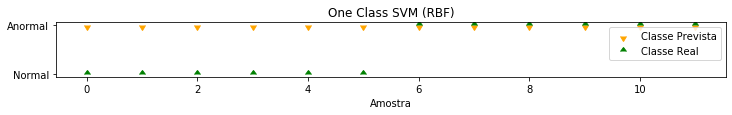

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


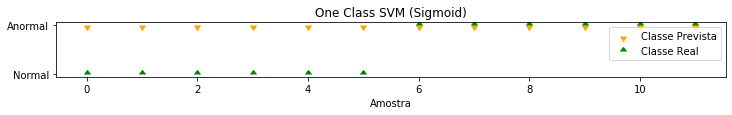

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1]


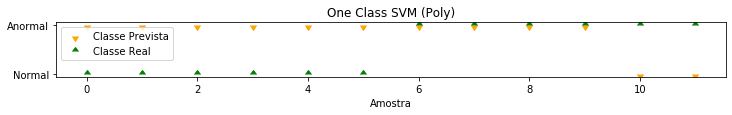

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1]


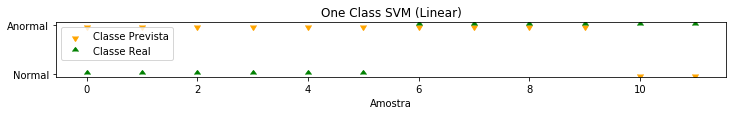

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[-1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


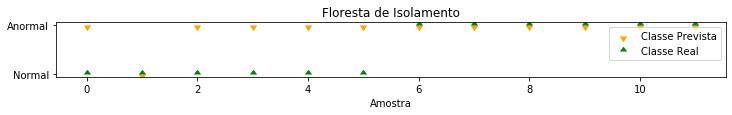

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


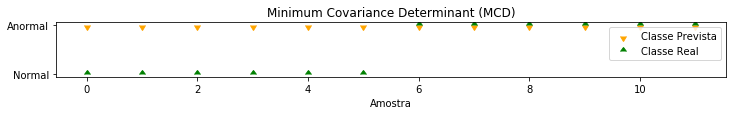

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1]


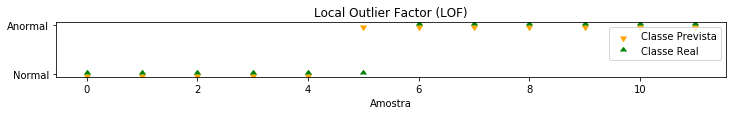

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


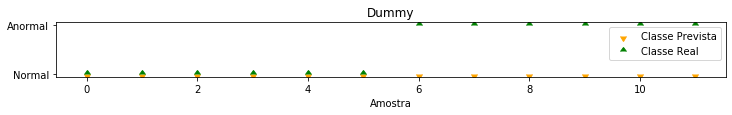

Instância 4: data\1\WELL-00006_20170802123000.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


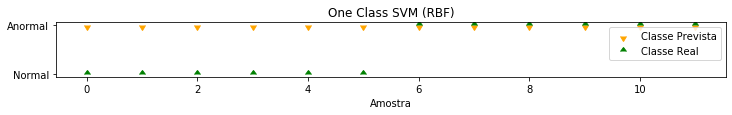

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[ 1  1 -1  1  1  1 -1 -1 -1 -1 -1 -1]


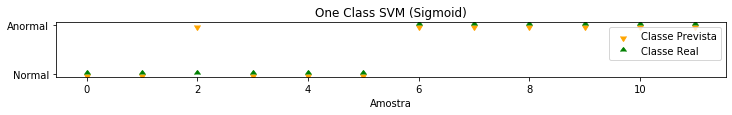

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


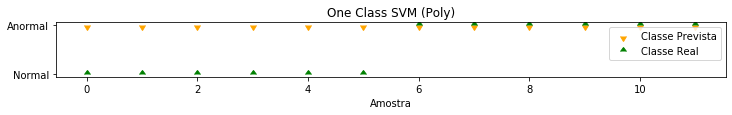

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[ 1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1]


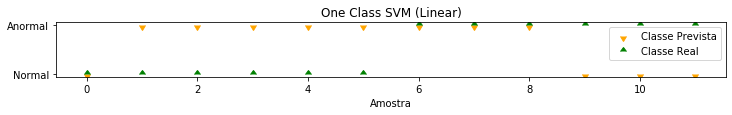

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[1 1 1 1 1 1 1 1 1 1 1 1]


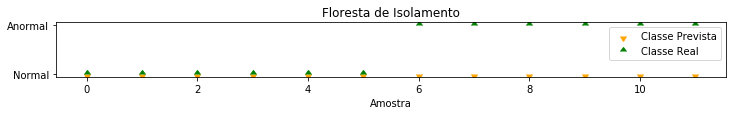

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


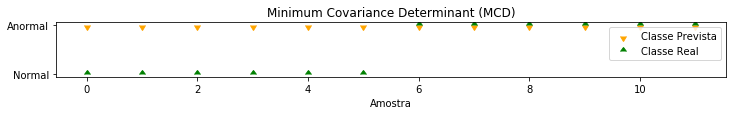

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1  1  1 -1 -1 -1 -1 -1]


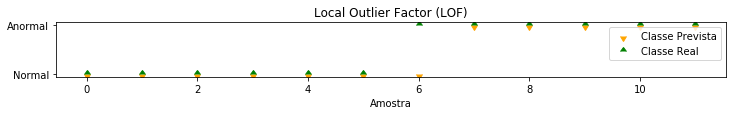

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


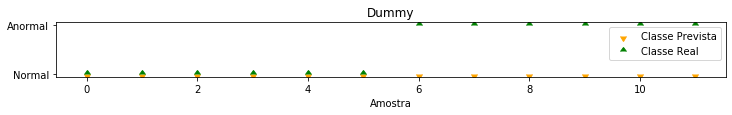

Instância 5: data\1\WELL-00006_20180618060245.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


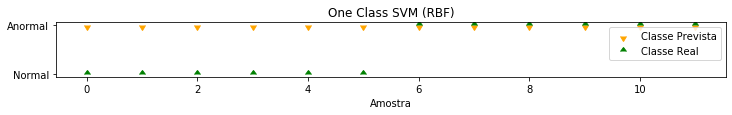

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[-1 -1  1  1 -1  1  1 -1 -1 -1 -1 -1]


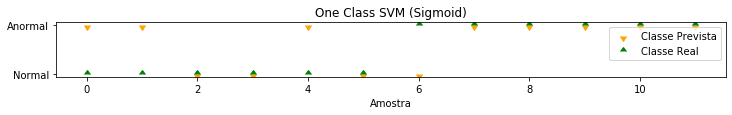

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[-1  1  1  1  1  1  1  1  1  1  1  1]


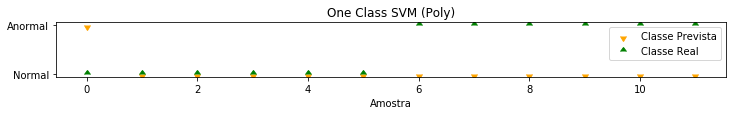

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[-1 -1  1  1  1  1  1  1  1  1  1  1]


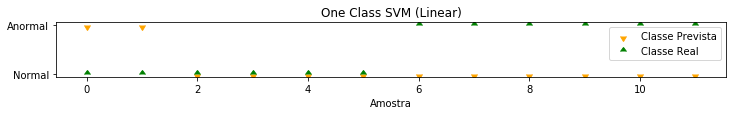

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1  1  1  1  1  1  1  1  1  1 -1  1]


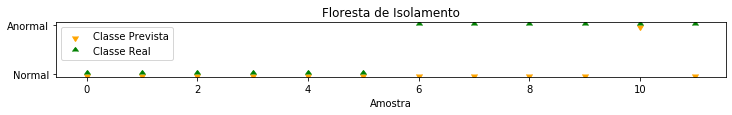

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


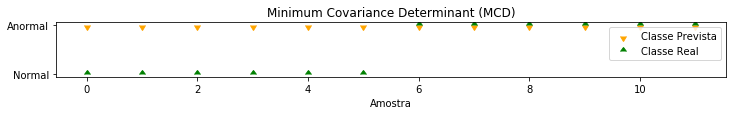

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]


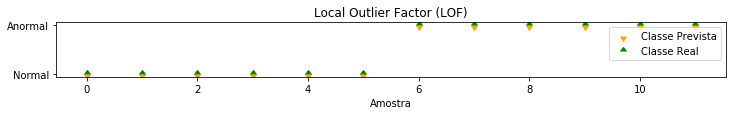

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


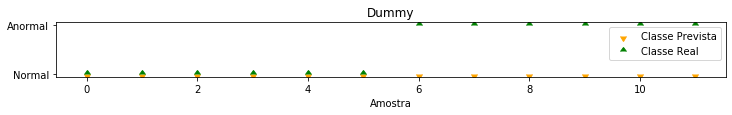

Instância 6: data\2\WELL-00002_20131104014101.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


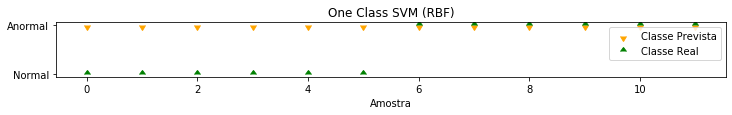

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[ 1 -1 -1  1  1  1  1  1  1  1  1  1]


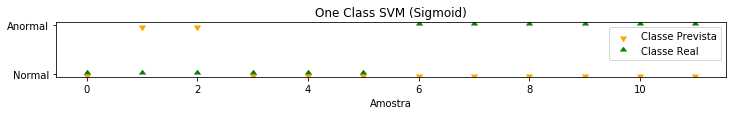

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[ 1 -1  1  1  1  1  1  1  1  1  1  1]


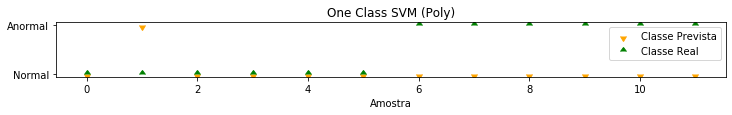

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[ 1 -1  1  1  1  1  1  1  1  1  1  1]


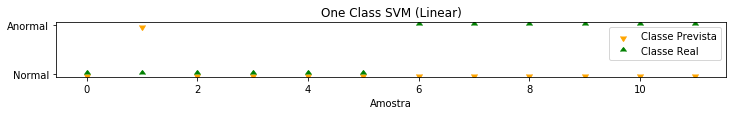

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


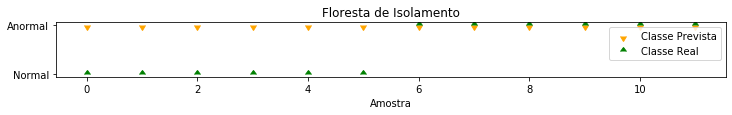

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


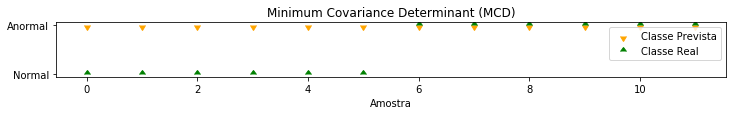

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


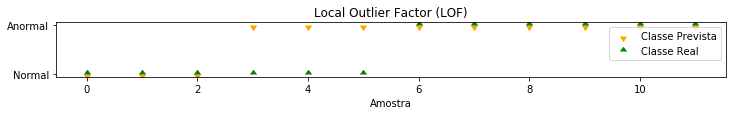

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


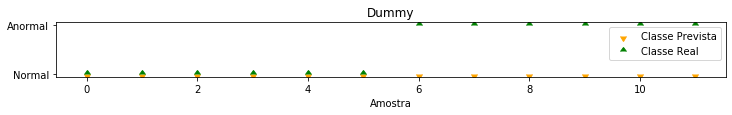

Instância 7: data\2\WELL-00003_20141122214325.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


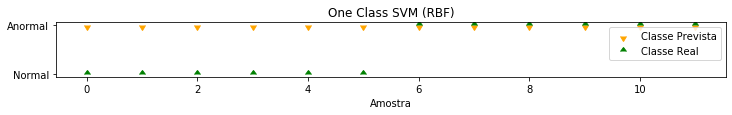

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[-1  1  1  1  1  1  1  1  1  1  1  1]


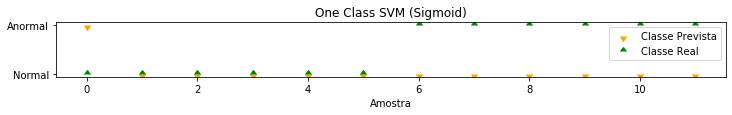

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[-1 -1  1  1  1  1  1  1  1  1  1  1]


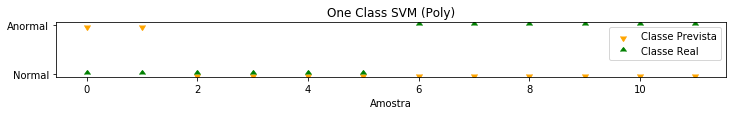

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[ 1  1  1  1  1  1  1  1 -1 -1 -1 -1]


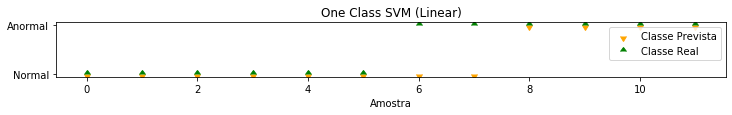

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1  1  1  1  1  1 -1 -1 -1  1  1  1]


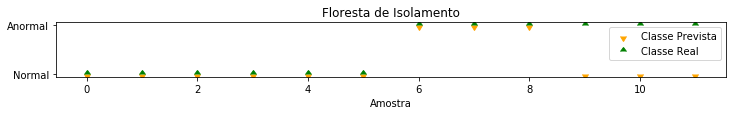

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


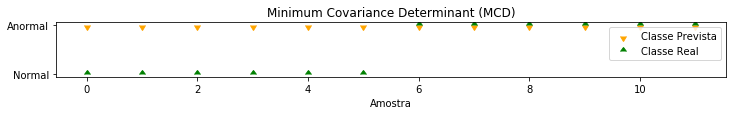

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]


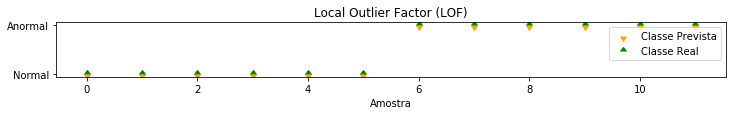

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


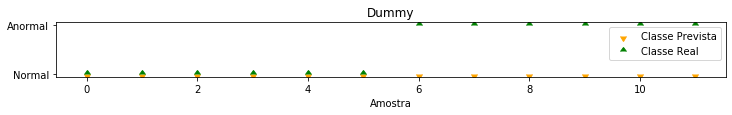

Instância 8: data\2\WELL-00003_20170728150240.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


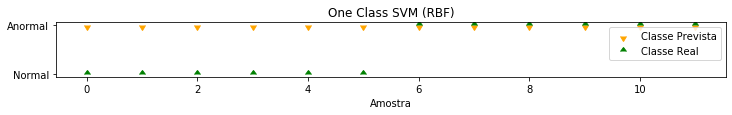

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[ 1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1]


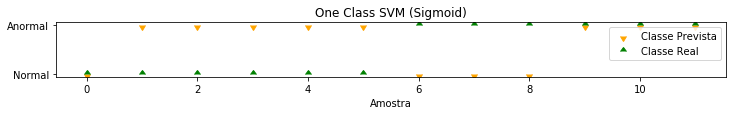

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[ 1  1  1  1  1  1  1  1  1 -1 -1 -1]


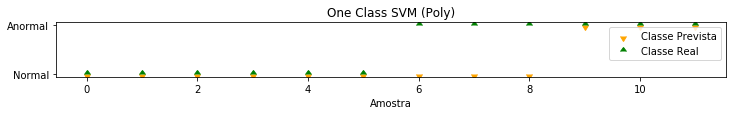

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[ 1  1 -1  1  1 -1  1  1  1 -1 -1 -1]


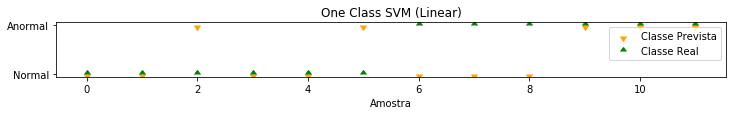

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1]


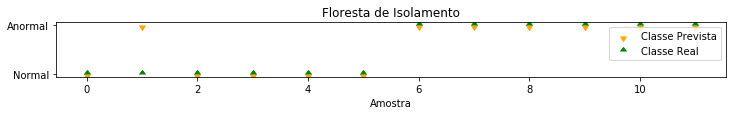

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


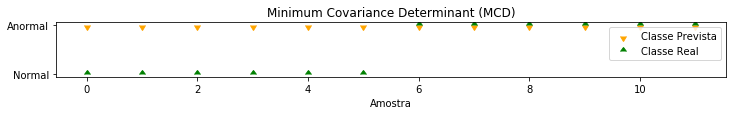

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


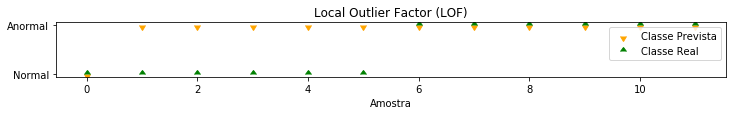

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


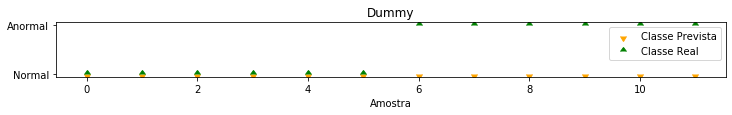

Instância 9: data\2\WELL-00003_20180206182917.csv
	ignorado porque normal_period_size é insuficiente para treinamento (586)

Instância 10: data\2\WELL-00009_20170313160804.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


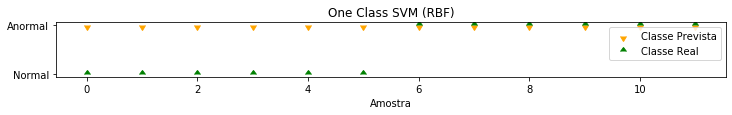

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[-1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]


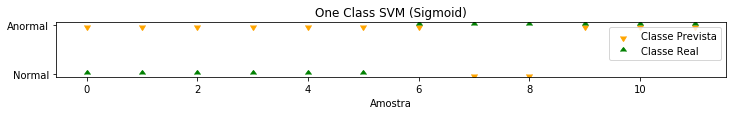

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[-1 -1  1  1  1  1  1  1  1 -1 -1 -1]


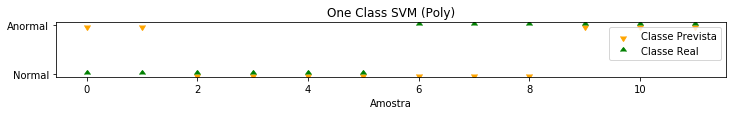

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[-1 -1 -1  1  1  1  1  1  1 -1 -1 -1]


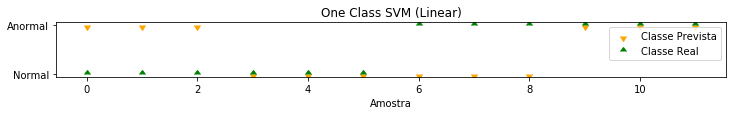

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1  1  1  1  1  1  1 -1 -1 -1 -1 -1]


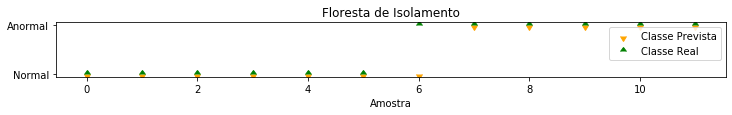

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


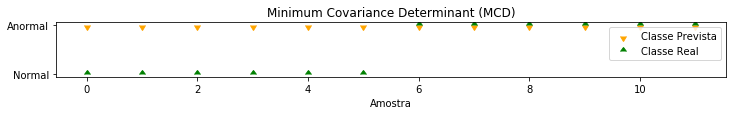

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1]


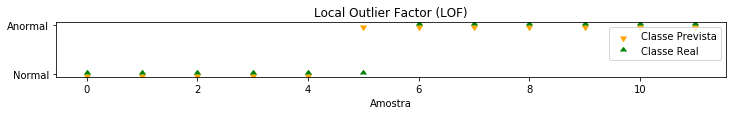

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


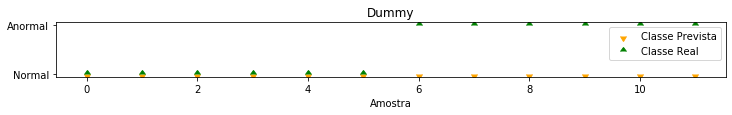

Instância 11: data\2\WELL-00010_20171218200131.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


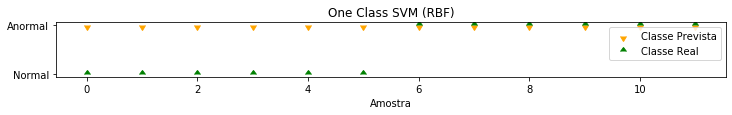

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[ 1 -1  1 -1 -1  1  1  1 -1 -1 -1 -1]


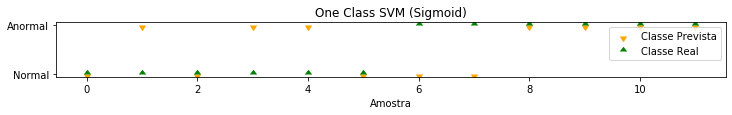

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[ 1  1  1  1  1  1  1  1  1 -1 -1 -1]


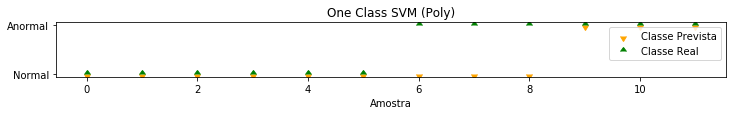

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[ 1 -1  1  1 -1  1  1  1  1  1  1  1]


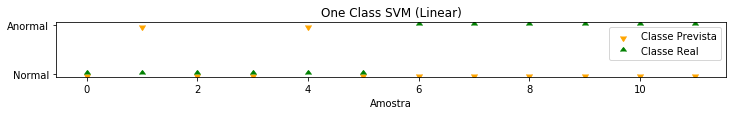

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1]


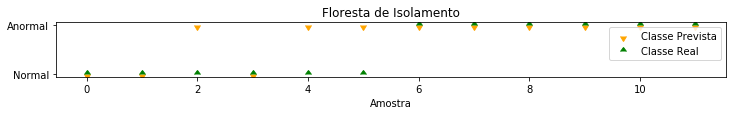

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


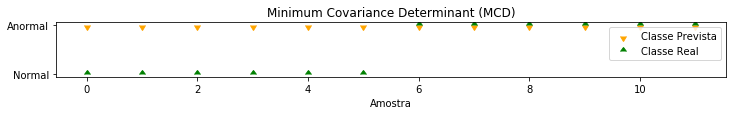

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1]


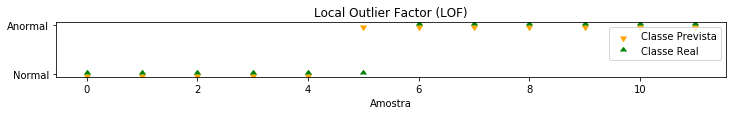

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


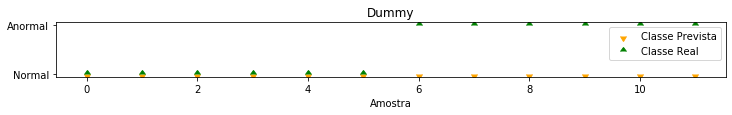

Instância 12: data\2\WELL-00011_20140515110134.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


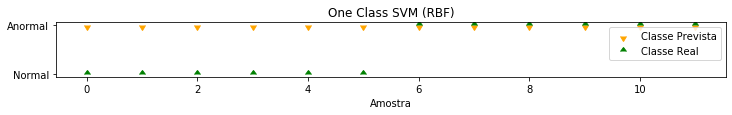

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


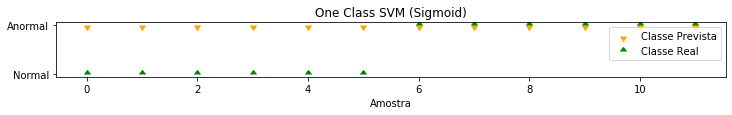

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


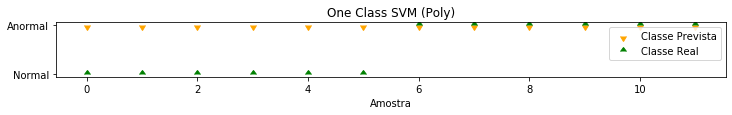

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


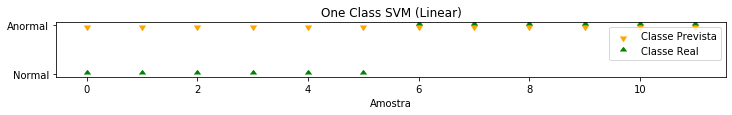

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[1 1 1 1 1 1 1 1 1 1 1 1]


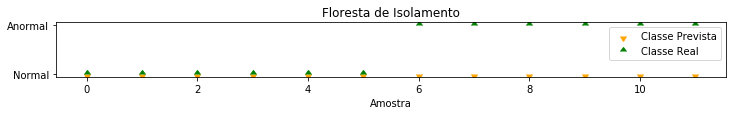

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[1 1 1 1 1 1 1 1 1 1 1 1]


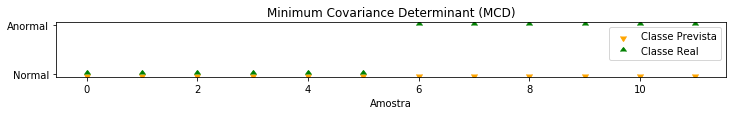

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[1 1 1 1 1 1 1 1 1 1 1 1]


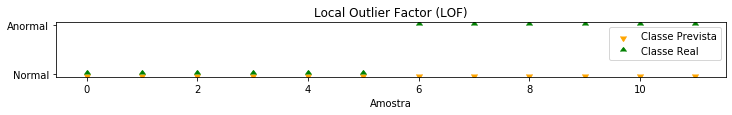

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


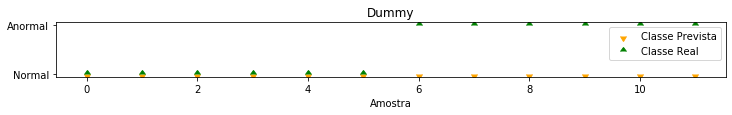

Instância 13: data\2\WELL-00011_20140530100015.csv
	ignorado porque normal_period_size é insuficiente para treinamento (482)

Instância 14: data\2\WELL-00011_20140606230115.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


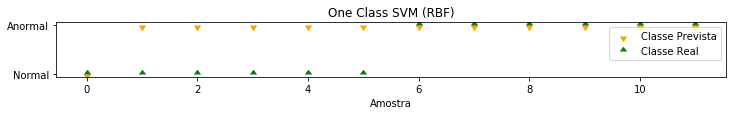

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[ 1 -1  1 -1 -1 -1  1  1 -1 -1 -1 -1]


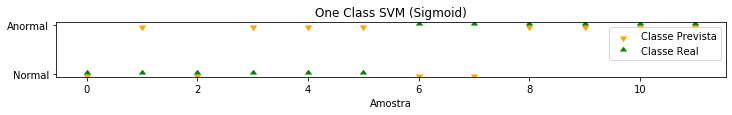

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[ 1 -1  1  1 -1 -1  1  1  1 -1 -1 -1]


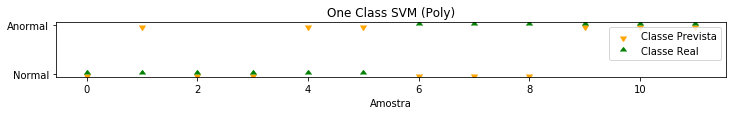

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[ 1 -1  1 -1 -1 -1  1  1  1 -1 -1 -1]


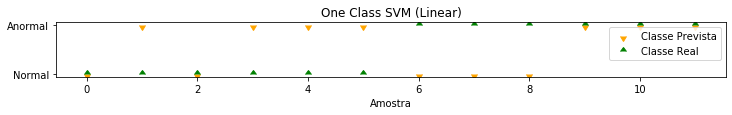

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1  1  1  1  1  1 -1 -1 -1  1  1  1]


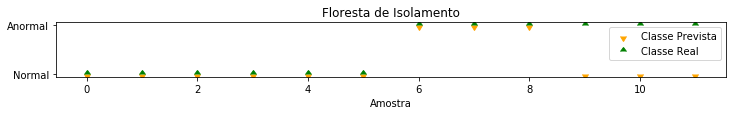

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


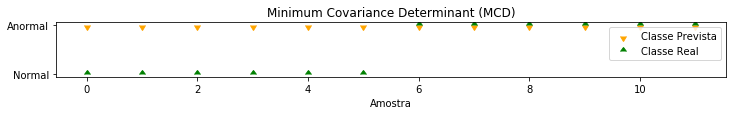

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]


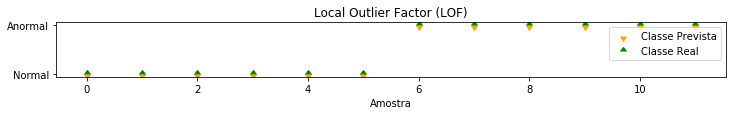

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


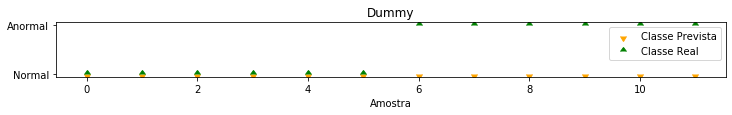

Instância 15: data\2\WELL-00011_20140720120102.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1]


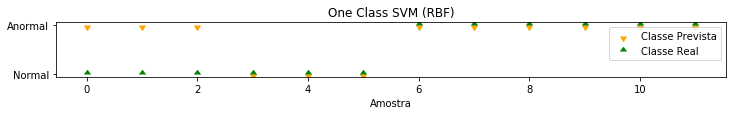

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[ 1 -1  1  1 -1 -1  1  1  1  1  1 -1]


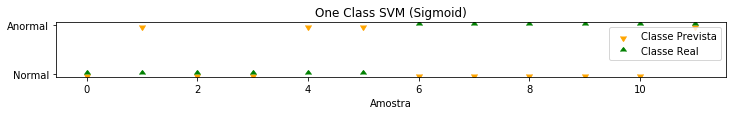

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[ 1 -1  1  1 -1 -1  1  1  1  1  1  1]


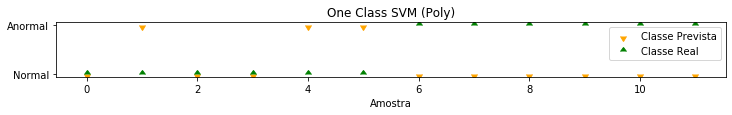

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[ 1 -1  1  1 -1 -1  1  1  1  1  1  1]


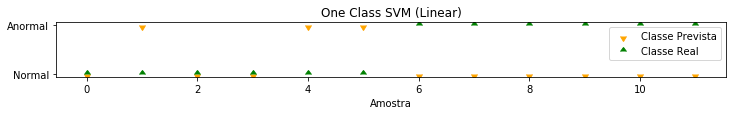

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1  1  1  1  1  1  1 -1 -1 -1 -1 -1]


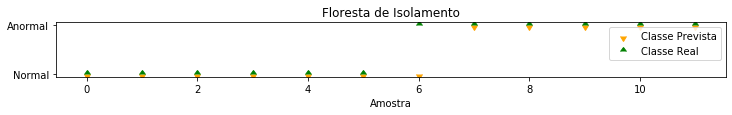

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]


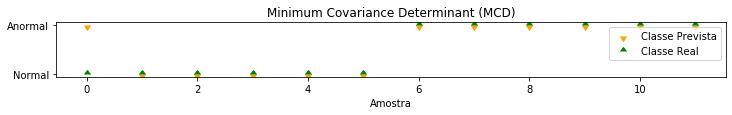

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]


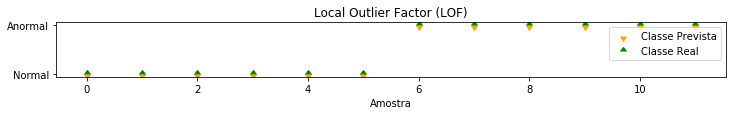

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


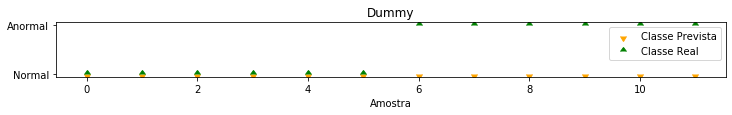

Instância 16: data\2\WELL-00011_20140726180015.csv
	ignorado porque normal_period_size é insuficiente para treinamento (900)

Instância 17: data\2\WELL-00011_20140824000118.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1]


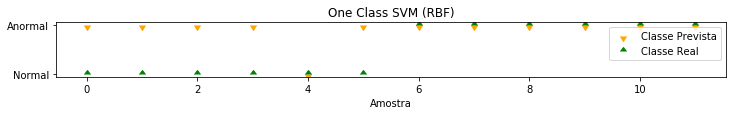

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[ 1 -1 -1  1 -1  1  1  1 -1 -1 -1 -1]


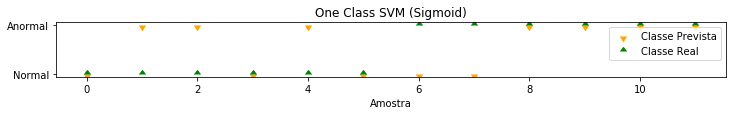

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[ 1 -1 -1  1 -1  1  1  1  1  1  1  1]


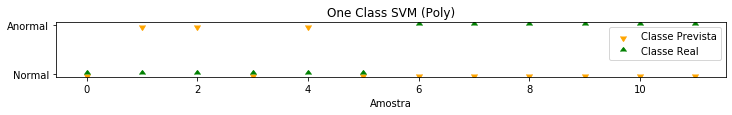

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[ 1 -1 -1  1 -1  1  1  1  1  1  1  1]


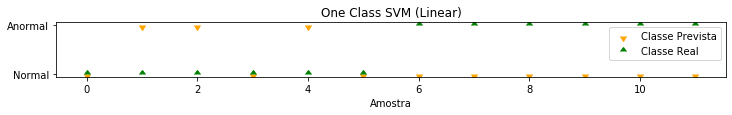

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1]


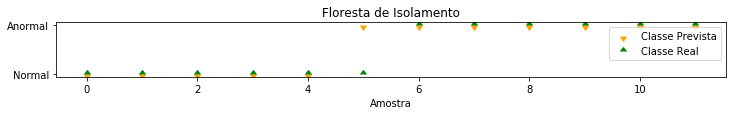

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1]


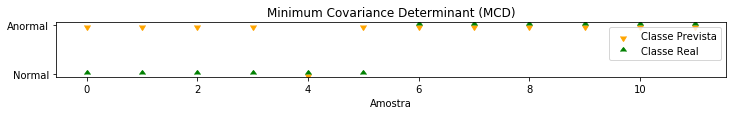

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]


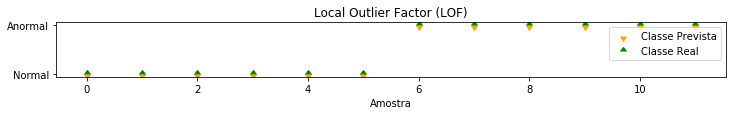

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


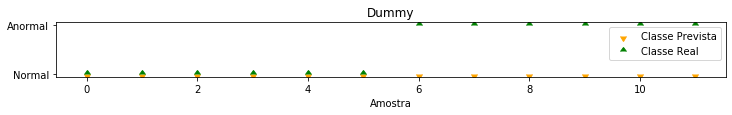

Instância 18: data\2\WELL-00011_20140916060300.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[ 1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


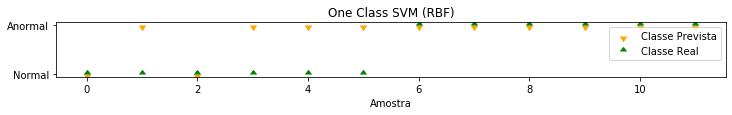

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[-1  1  1 -1  1  1  1  1  1  1  1  1]


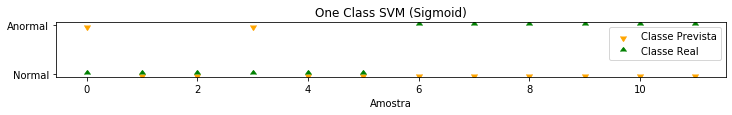

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[-1  1  1 -1  1  1  1  1  1  1  1  1]


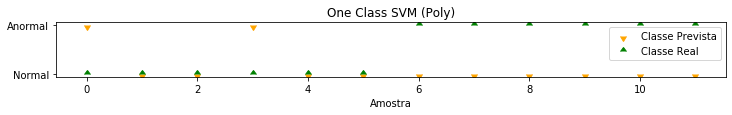

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[-1  1  1 -1  1  1  1  1  1  1  1  1]


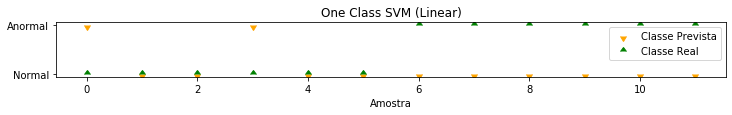

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1 -1  1  1 -1  1  1 -1 -1 -1 -1 -1]


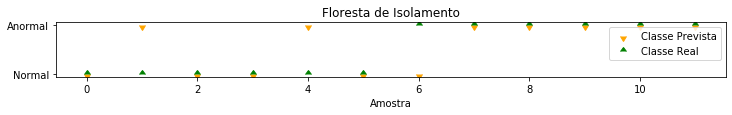

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


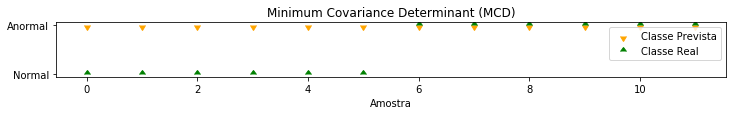

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1  1  1 -1 -1 -1 -1 -1]


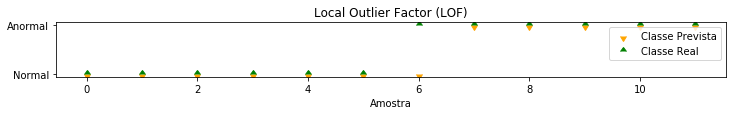

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


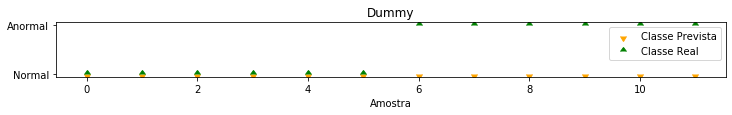

Instância 19: data\2\WELL-00011_20140921200031.csv
	ignorado porque normal_period_size é insuficiente para treinamento (695)

Instância 20: data\2\WELL-00011_20140928100056.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[ 1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1]


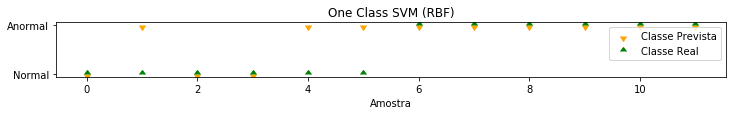

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[-1 -1 -1 -1 -1  1  1  1  1  1  1  1]


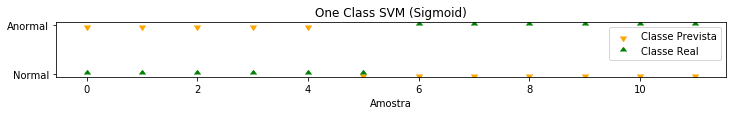

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[-1 -1 -1 -1 -1  1  1  1  1  1  1  1]


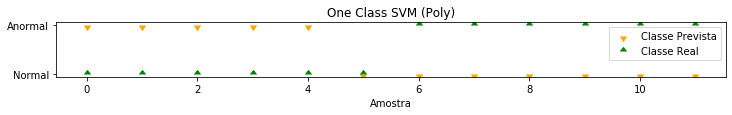

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[-1 -1 -1 -1 -1  1  1  1  1  1  1  1]


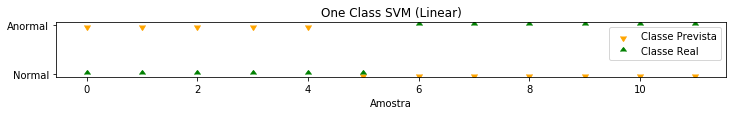

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]


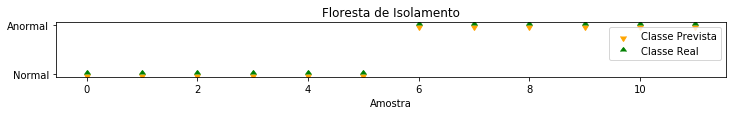

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


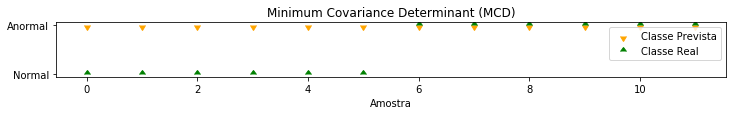

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]


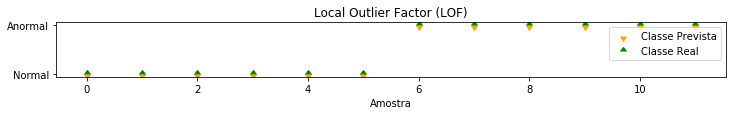

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


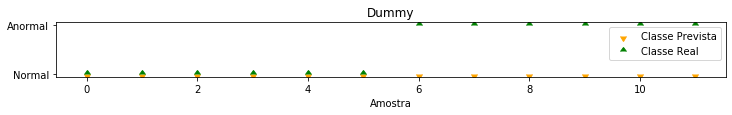

Instância 21: data\2\WELL-00011_20140929170028.csv
	ignorado porque normal_period_size é insuficiente para treinamento (975)

Instância 22: data\2\WELL-00011_20140929220121.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


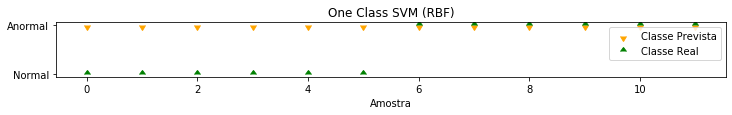

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[ 1 -1 -1 -1 -1 -1 -1  1  1  1  1  1]


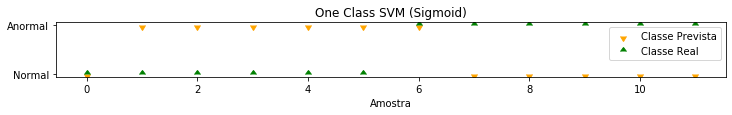

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[1 1 1 1 1 1 1 1 1 1 1 1]


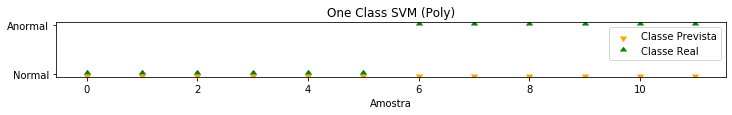

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[ 1 -1 -1 -1  1 -1 -1  1  1  1  1  1]


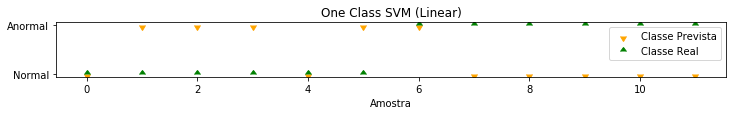

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1  1  1  1  1  1  1 -1 -1 -1 -1 -1]


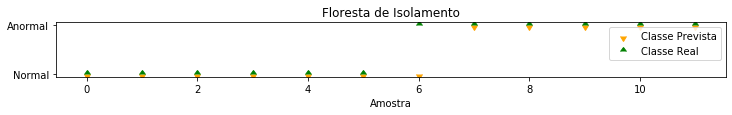

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


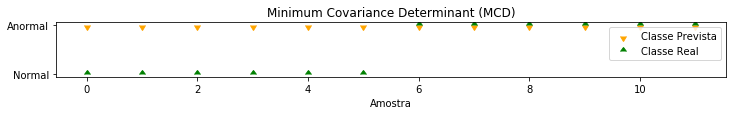

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1  1  1 -1 -1 -1 -1 -1]


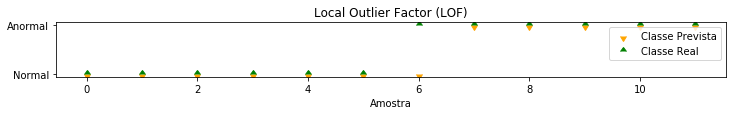

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


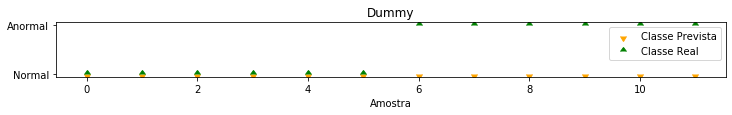

Instância 23: data\2\WELL-00011_20141005170056.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[ 1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1]


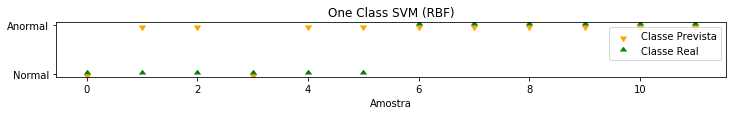

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[-1 -1 -1  1  1 -1  1  1  1 -1 -1 -1]


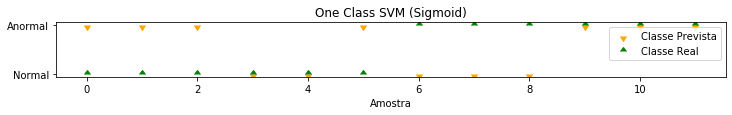

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[-1 -1 -1  1  1 -1  1  1  1  1  1  1]


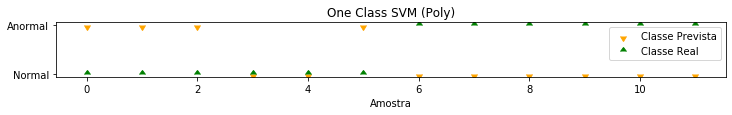

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[-1 -1 -1  1  1 -1  1  1  1  1  1 -1]


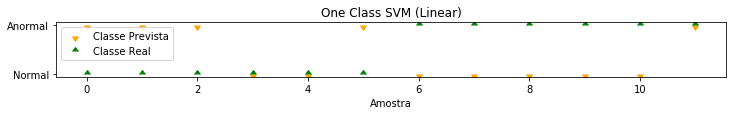

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]


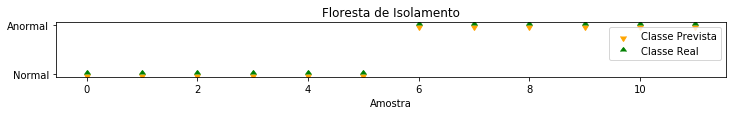

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1]


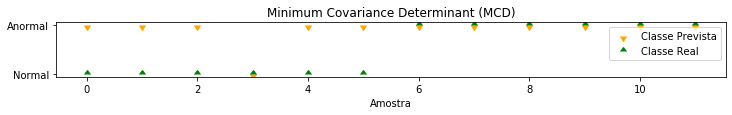

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]


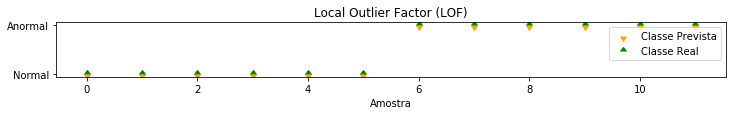

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


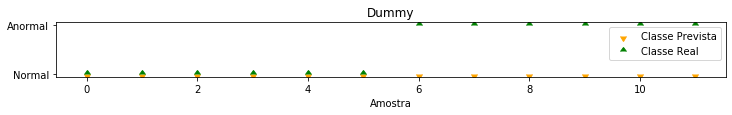

Instância 24: data\2\WELL-00011_20141006160121.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


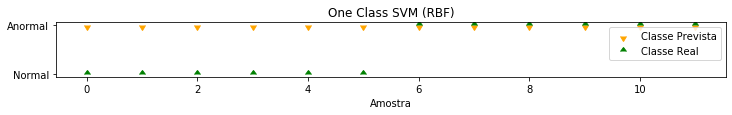

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[ 1  1 -1  1  1  1  1  1  1  1  1  1]


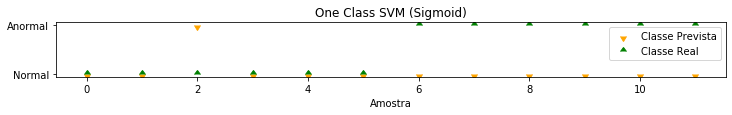

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[-1  1 -1  1  1  1  1  1  1  1  1  1]


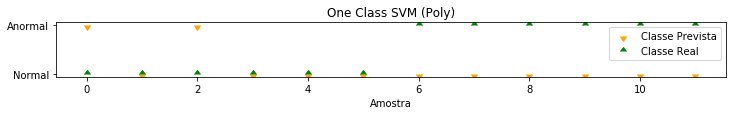

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[ 1  1 -1  1  1  1  1  1  1  1  1  1]


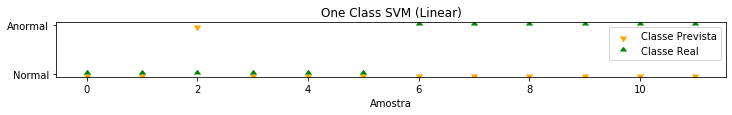

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1  1  1  1  1  1  1  1 -1 -1 -1 -1]


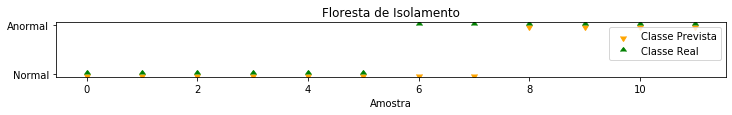

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


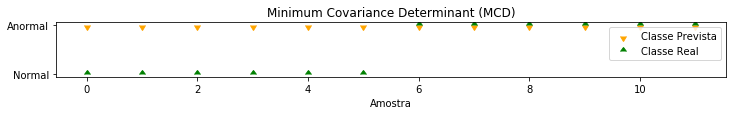

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1  1  1 -1 -1 -1 -1 -1]


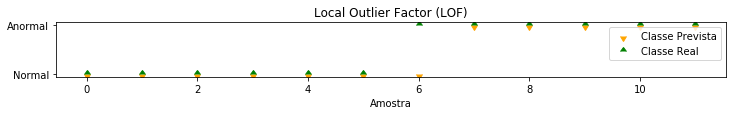

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


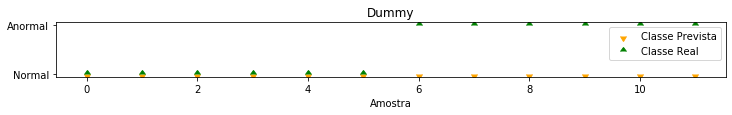

Instância 25: data\2\WELL-00012_20170320033022.csv
	ignorado porque normal_period_size é insuficiente para treinamento (773)

Instância 26: data\2\WELL-00012_20170320143144.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


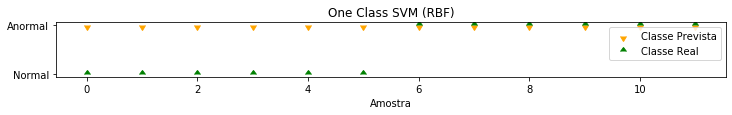

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[-1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1]


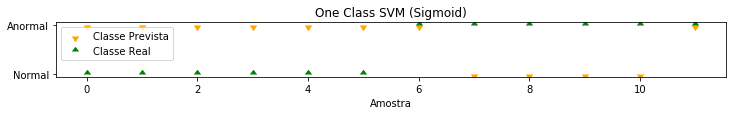

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[1 1 1 1 1 1 1 1 1 1 1 1]


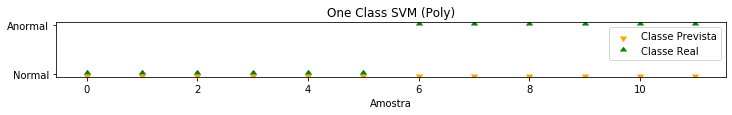

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[ 1  1  1  1 -1 -1 -1  1  1  1  1  1]


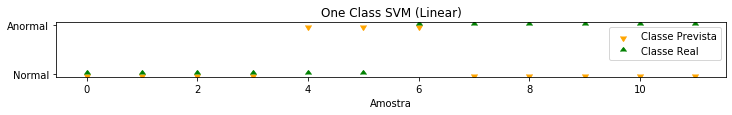

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1  1  1 -1  1  1  1 -1 -1 -1 -1 -1]


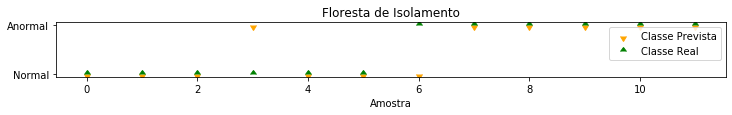

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


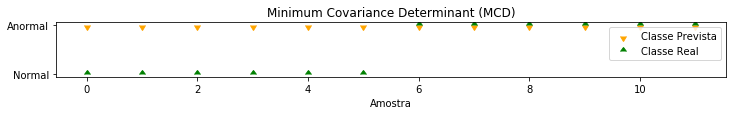

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1]


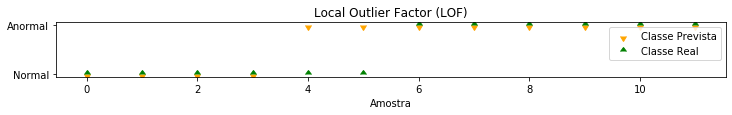

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


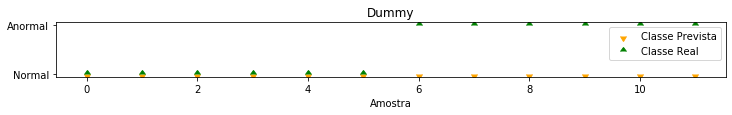

Instância 27: data\2\WELL-00013_20170329020229.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1  1  1 -1  1  1 -1 -1 -1 -1 -1 -1]


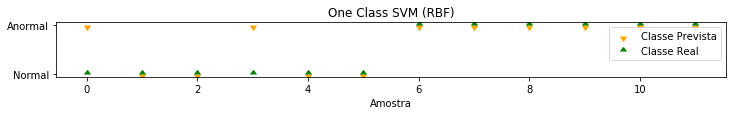

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[ 1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]


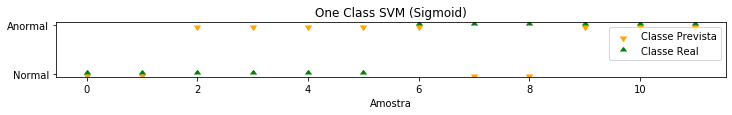

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[ 1  1 -1  1 -1 -1  1  1  1 -1 -1 -1]


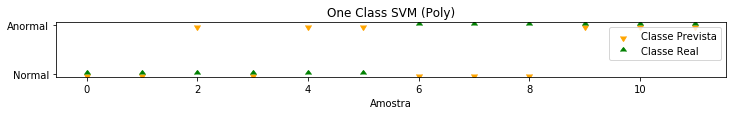

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[ 1  1 -1 -1 -1 -1 -1  1  1  1  1  1]


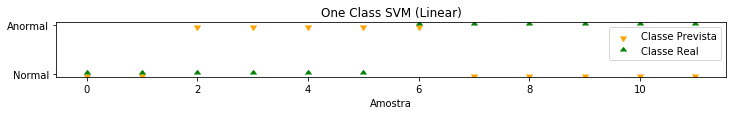

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[-1  1  1  1  1  1  1 -1 -1 -1 -1 -1]


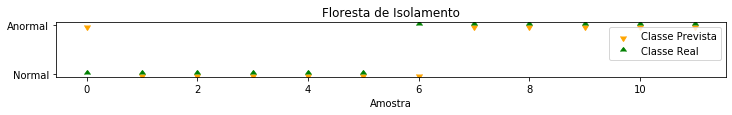

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1  1  1  1  1  1  1 -1 -1 -1 -1 -1]


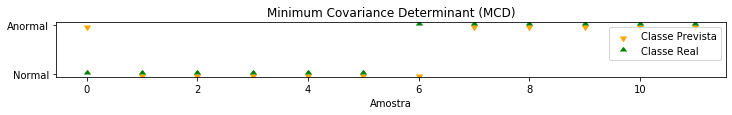

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1  1  1 -1 -1 -1 -1 -1]


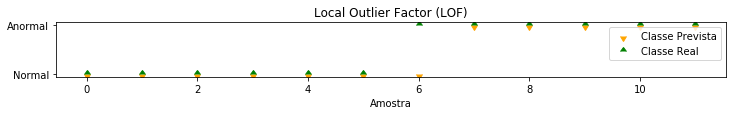

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


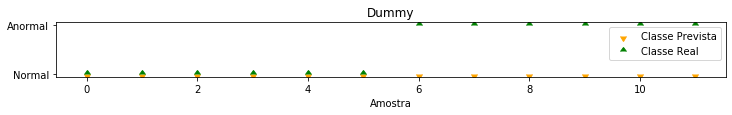

Instância 28: data\5\WELL-00015_20170620160349.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


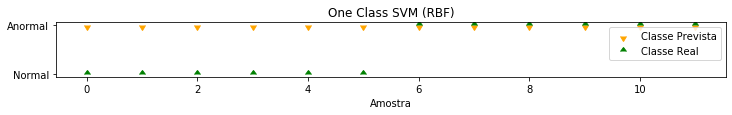

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[-1  1  1  1  1  1  1  1 -1  1  1  1]


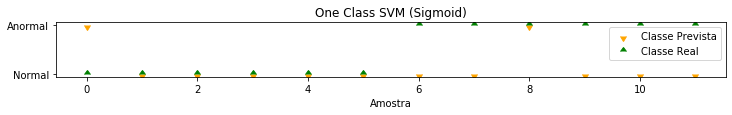

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[-1 -1  1  1  1  1  1  1  1 -1 -1 -1]


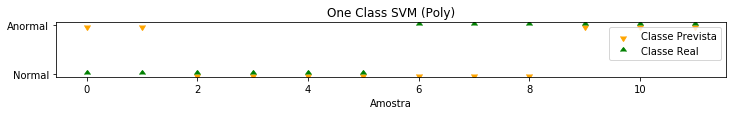

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[1 1 1 1 1 1 1 1 1 1 1 1]


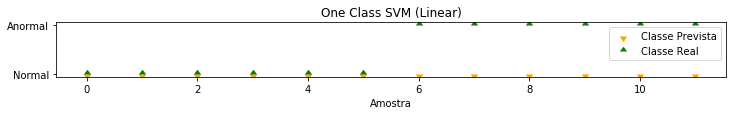

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1]


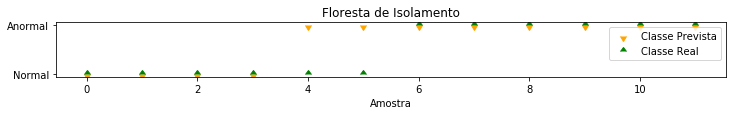

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


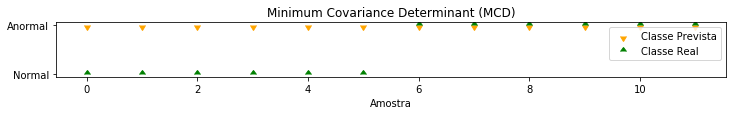

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1]


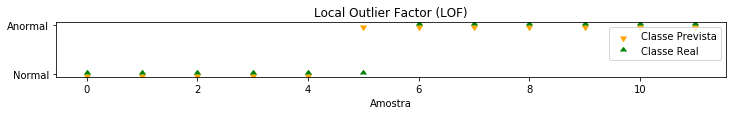

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


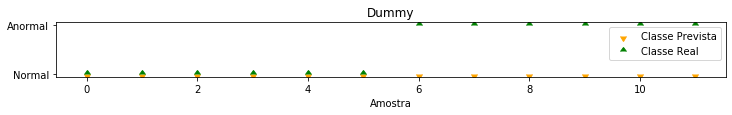

Instância 29: data\5\WELL-00015_20171013140047.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


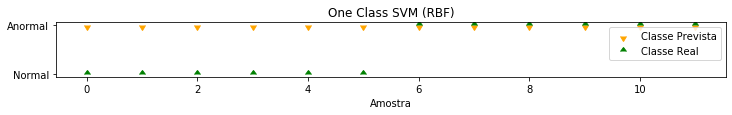

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


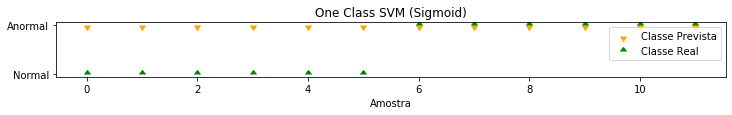

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[ 1  1  1  1 -1  1  1  1  1  1  1  1]


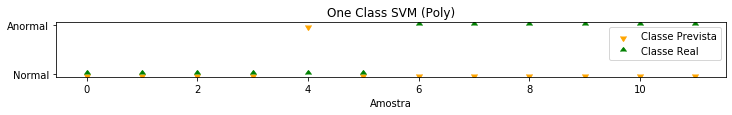

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[-1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


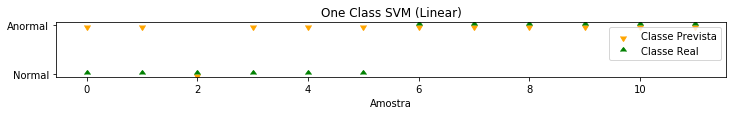

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1  1  1  1  1  1  1 -1 -1 -1 -1 -1]


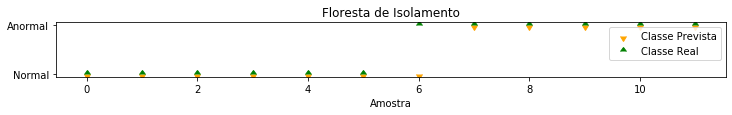

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


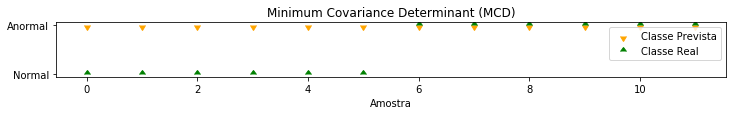

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1  1  1 -1 -1 -1 -1 -1]


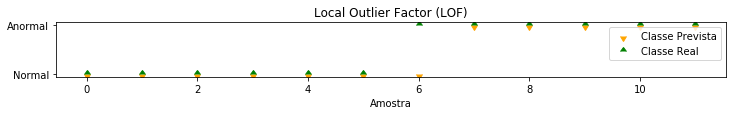

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


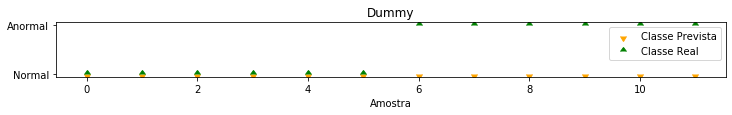

Instância 30: data\5\WELL-00016_20180405020345.csv
	ignorado porque normal_period_size é insuficiente para treinamento (1145)

Instância 31: data\5\WELL-00016_20180426142005.csv
	ignorado porque normal_period_size é insuficiente para treinamento (321)

Instância 32: data\5\WELL-00016_20180426145108.csv
	ignorado porque normal_period_size é insuficiente para treinamento (376)

Instância 33: data\5\WELL-00016_20180517222322.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


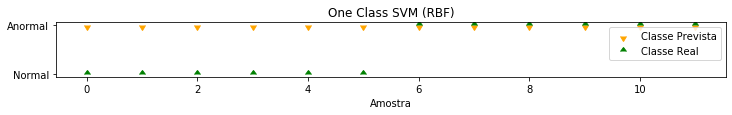

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[-1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]


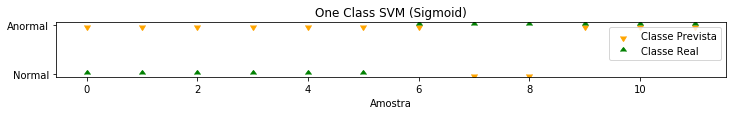

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[ 1  1 -1 -1 -1 -1  1  1  1  1  1  1]


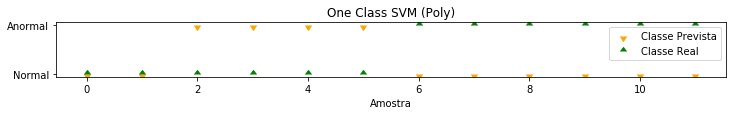

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[ 1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]


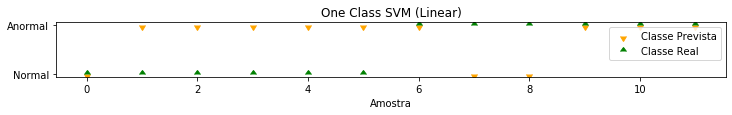

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[-1  1  1  1  1  1  1  1  1  1  1 -1]


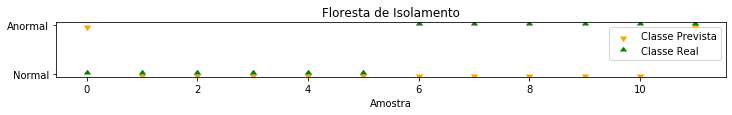

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


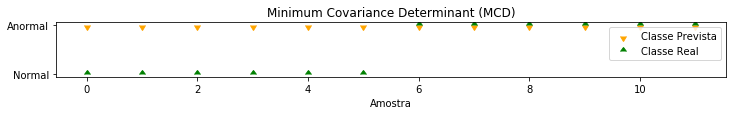

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


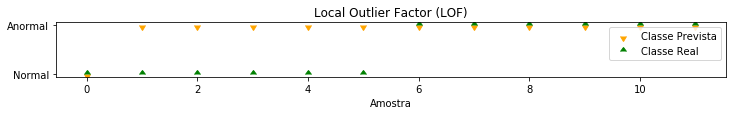

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


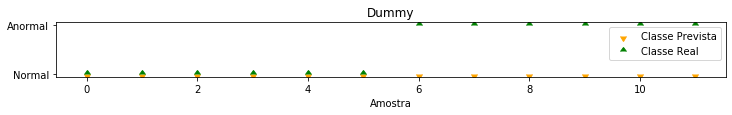

Instância 34: data\5\WELL-00017_20140314180000.csv
	ignorado porque normal_period_size é insuficiente para treinamento (0)

Instância 35: data\5\WELL-00017_20140317151743.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


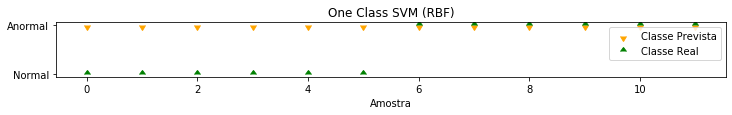

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[1 1 1 1 1 1 1 1 1 1 1 1]


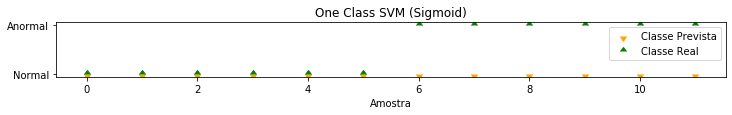

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[1 1 1 1 1 1 1 1 1 1 1 1]


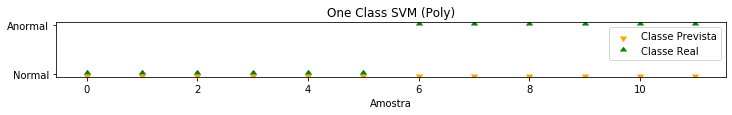

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[1 1 1 1 1 1 1 1 1 1 1 1]


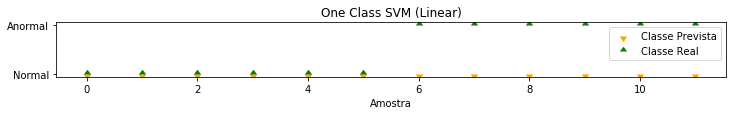

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[-1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1]


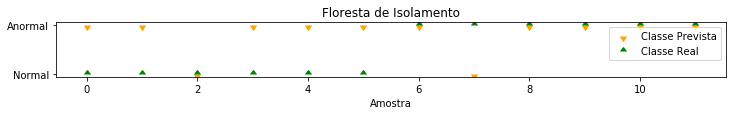

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


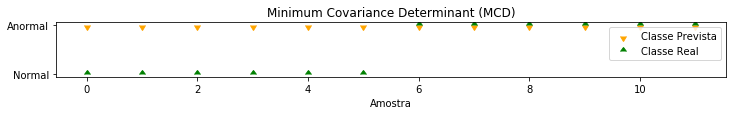

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]


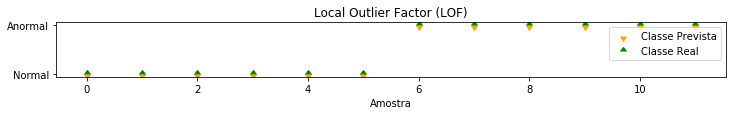

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


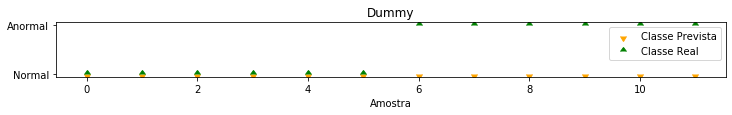

Instância 36: data\5\WELL-00017_20140318023141.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


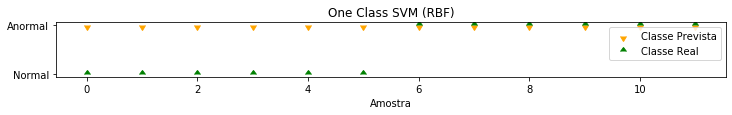

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[-1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


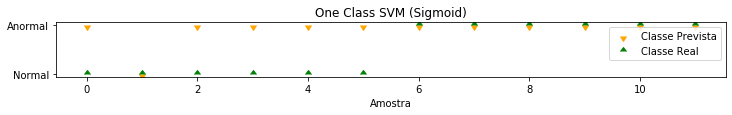

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[-1  1  1 -1  1  1  1  1 -1 -1 -1 -1]


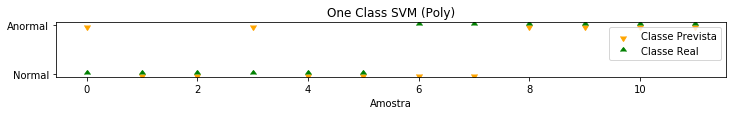

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[-1  1  1 -1 -1  1 -1 -1 -1 -1 -1 -1]


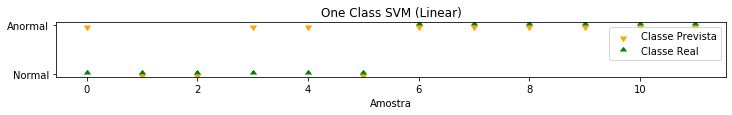

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1  1  1 -1 -1  1 -1 -1 -1 -1 -1 -1]


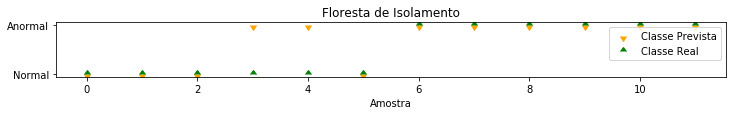

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


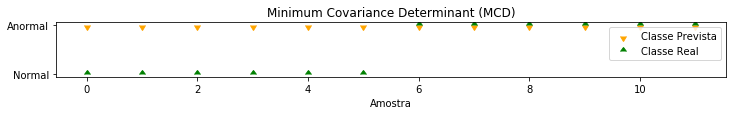

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]


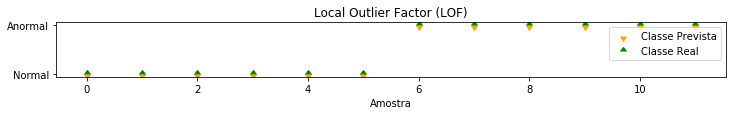

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


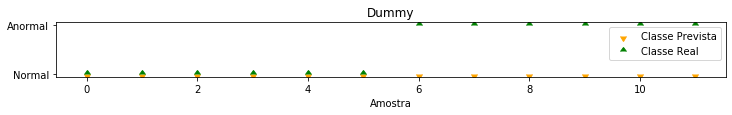

Instância 37: data\5\WELL-00017_20140318160220.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


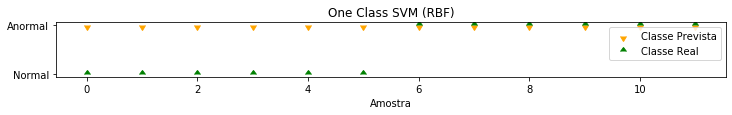

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[-1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


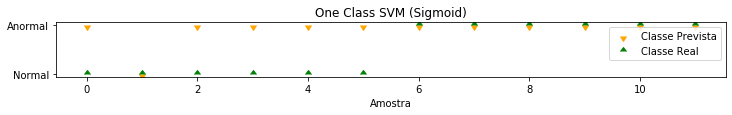

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[-1  1  1  1  1  1  1  1  1  1  1  1]


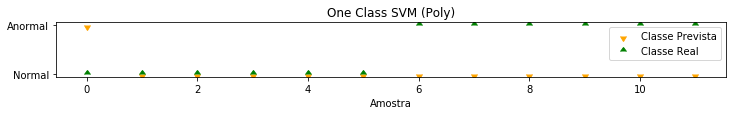

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[-1  1 -1 -1  1  1  1  1  1  1  1  1]


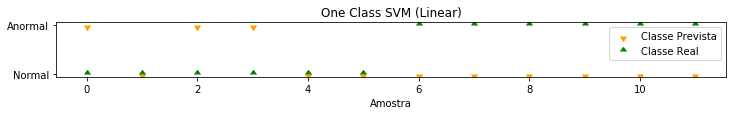

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


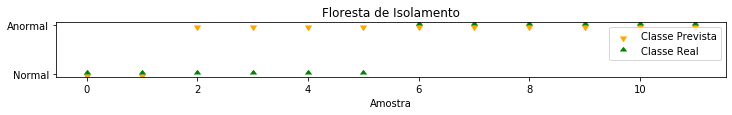

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


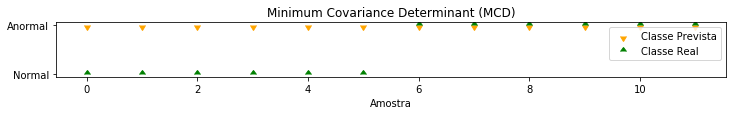

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1  1  1 -1 -1 -1 -1 -1]


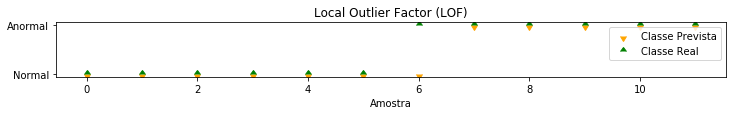

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


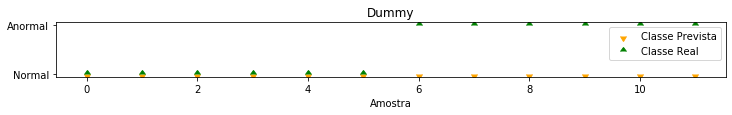

Instância 38: data\5\WELL-00017_20140319040453.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


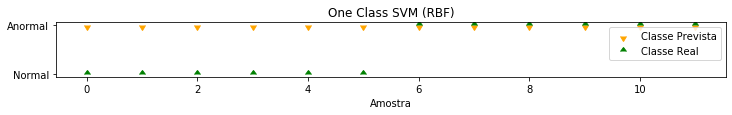

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


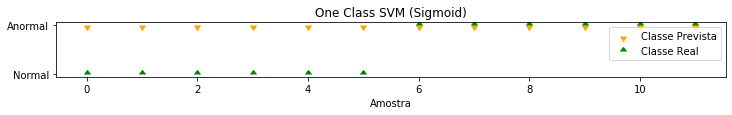

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[-1 -1  1  1  1  1  1  1  1  1  1  1]


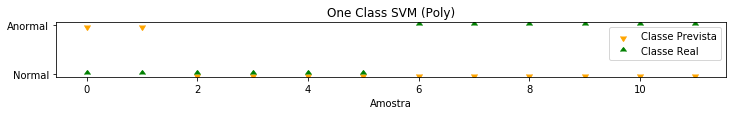

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[-1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1]


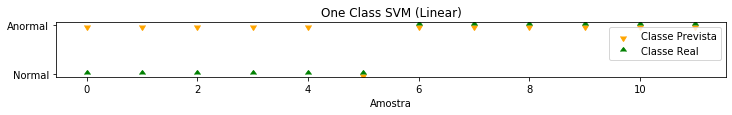

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1]


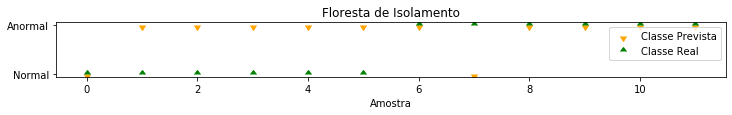

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


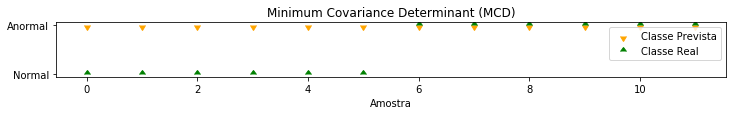

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]


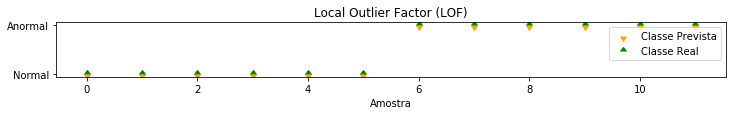

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


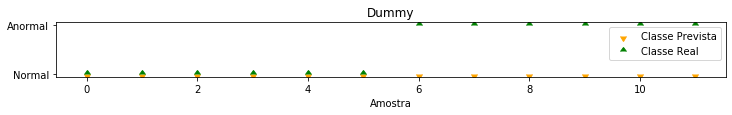

Instância 39: data\5\WELL-00017_20140319141450.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


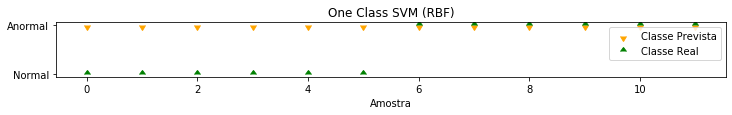

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[-1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


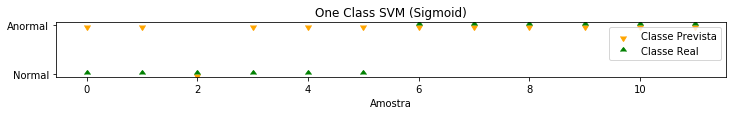

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[ 1  1  1  1  1  1  1  1 -1  1 -1 -1]


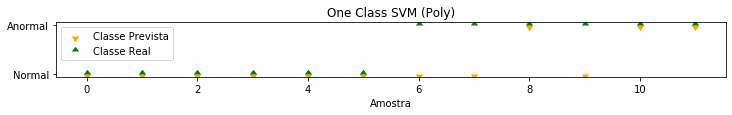

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[-1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1]


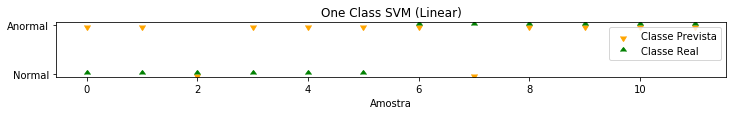

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1  1 -1  1  1  1  1 -1  1 -1 -1 -1]


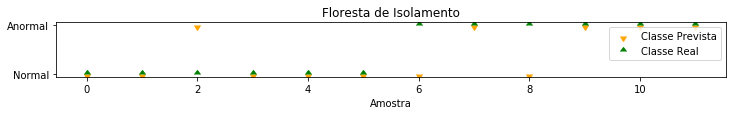

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


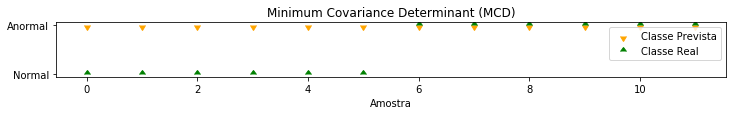

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


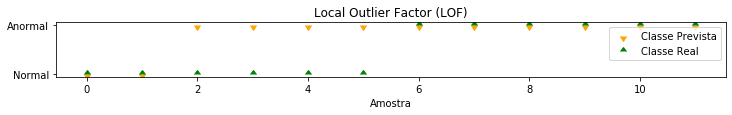

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


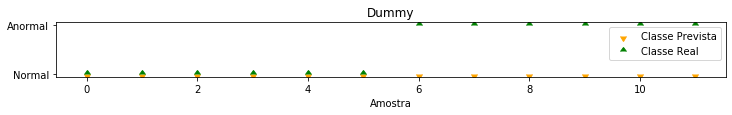

Instância 40: data\6\WELL-00002_20140212170333.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


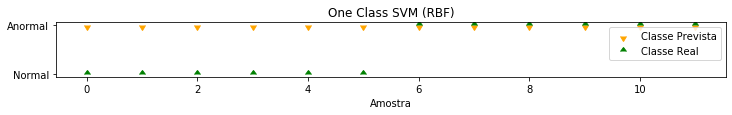

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[-1  1  1  1  1  1  1  1  1  1  1  1]


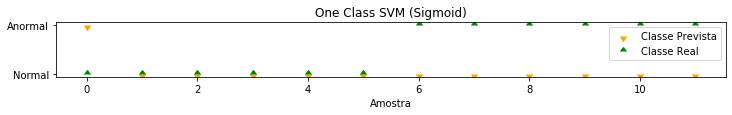

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[ 1  1 -1 -1 -1 -1 -1  1  1  1  1  1]


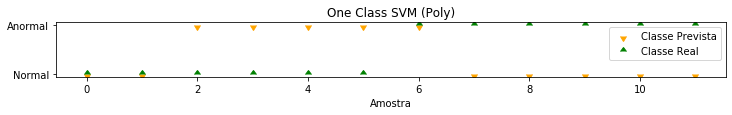

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[-1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1]


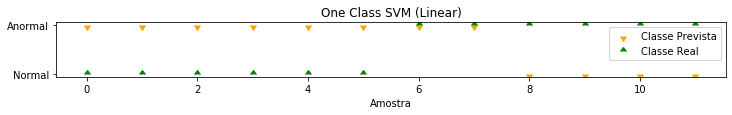

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1  1  1  1  1  1 -1  1  1  1  1  1]


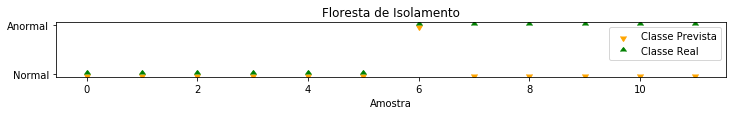

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


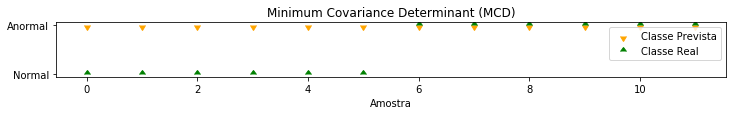

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1 -1 -1 -1  1  1 -1 -1 -1]


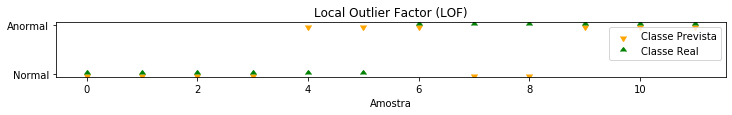

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


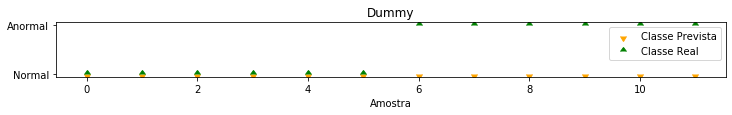

Instância 41: data\6\WELL-00002_20140301151700.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


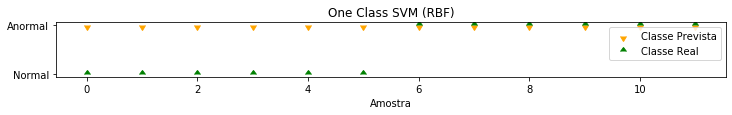

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1]


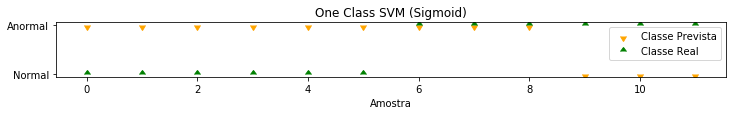

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[ 1  1  1  1  1  1  1  1  1 -1 -1 -1]


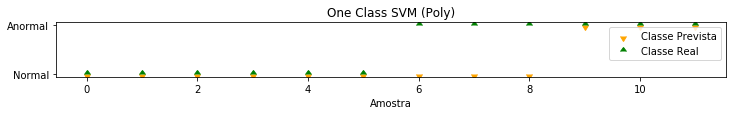

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[-1 -1 -1  1 -1  1  1  1  1  1  1  1]


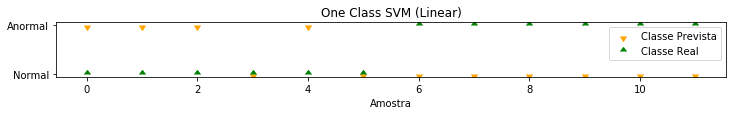

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[-1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


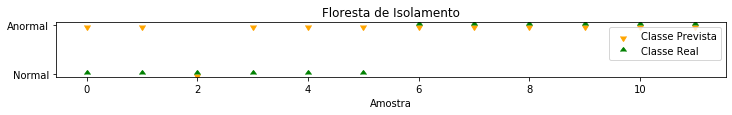

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


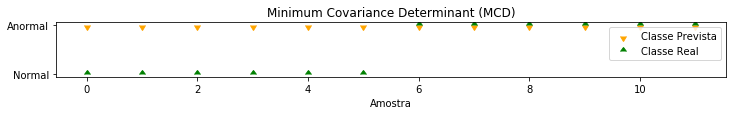

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1]


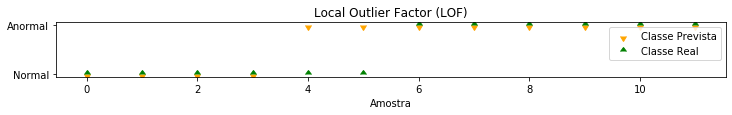

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


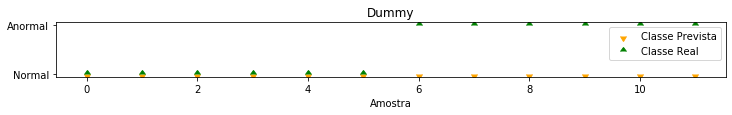

Instância 42: data\6\WELL-00002_20140325170304.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


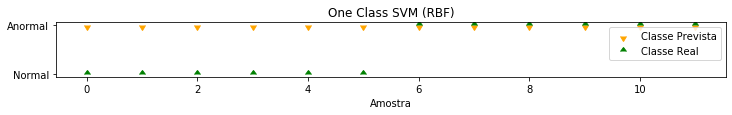

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[-1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1]


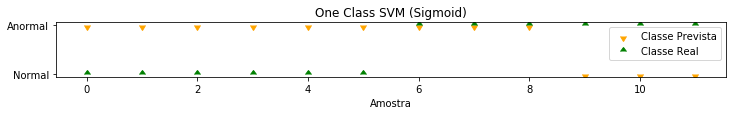

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[-1 -1  1  1  1  1 -1  1  1 -1 -1 -1]


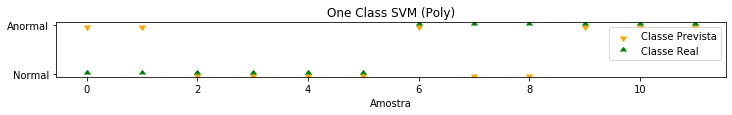

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[-1 -1 -1 -1 -1  1 -1  1  1 -1 -1 -1]


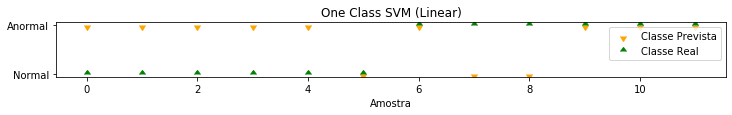

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1  1  1  1  1 -1  1  1  1 -1 -1 -1]


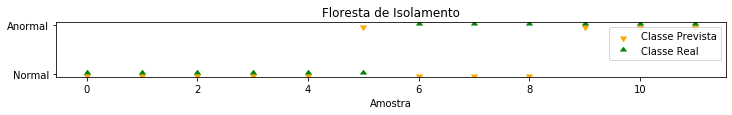

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


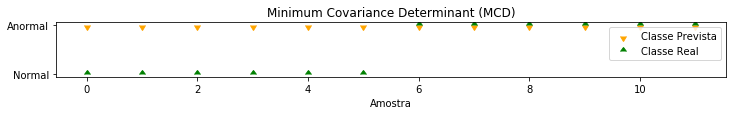

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1 -1 -1 -1  1 -1 -1 -1]


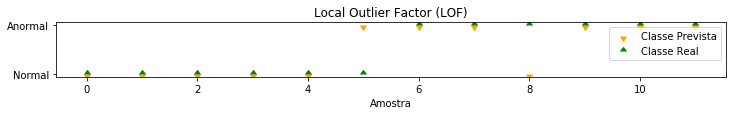

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


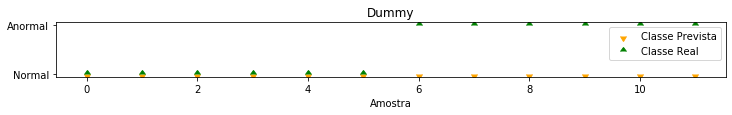

Instância 43: data\6\WELL-00004_20171031181509.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


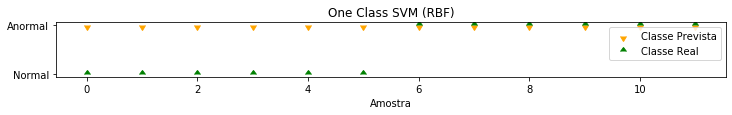

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[ 1  1  1  1  1  1  1  1  1 -1 -1 -1]


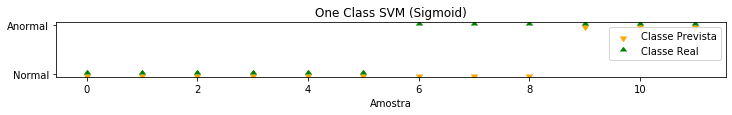

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[ 1  1  1  1  1  1  1  1  1 -1 -1 -1]


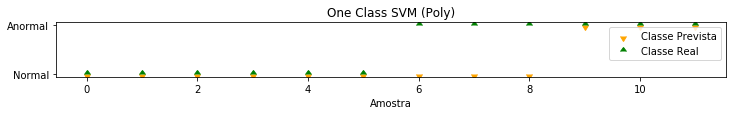

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[ 1  1  1  1  1  1  1  1  1 -1 -1 -1]


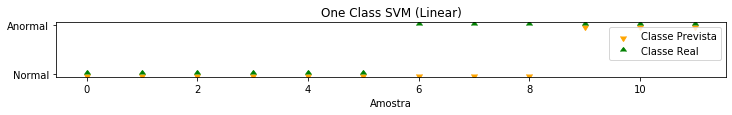

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[1 1 1 1 1 1 1 1 1 1 1 1]


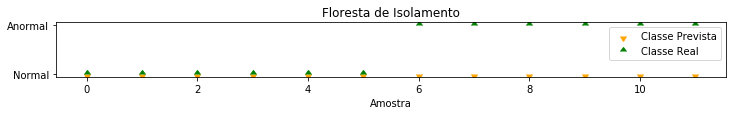

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


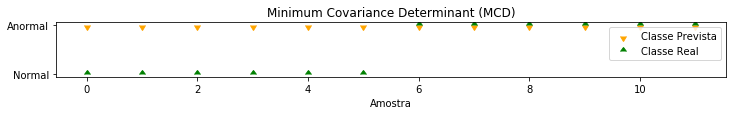

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


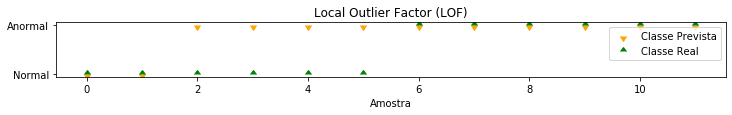

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


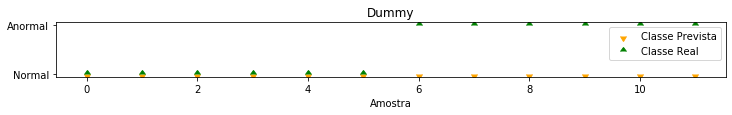

Instância 44: data\6\WELL-00004_20171031193025.csv
	ignorado porque normal_period_size é insuficiente para treinamento (414)

Instância 45: data\6\WELL-00004_20171031200059.csv
	ignorado porque normal_period_size é insuficiente para treinamento (845)

Instância 46: data\7\WELL-00001_20170226220309.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


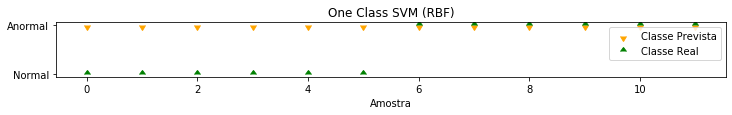

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[ 1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


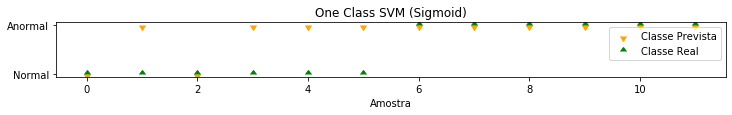

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[ 1  1  1 -1  1 -1  1  1  1  1  1  1]


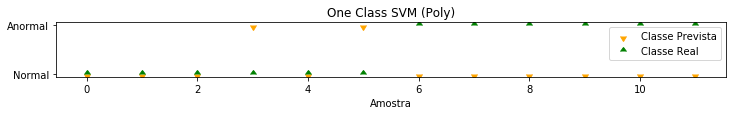

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[ 1 -1  1 -1 -1 -1 -1  1  1  1  1  1]


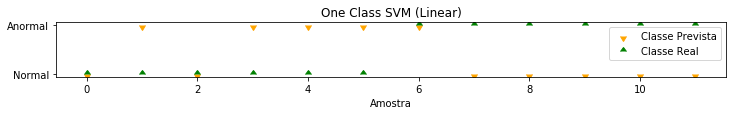

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1 -1 -1  1  1  1  1  1 -1 -1 -1 -1]


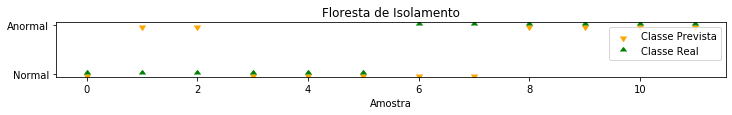

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


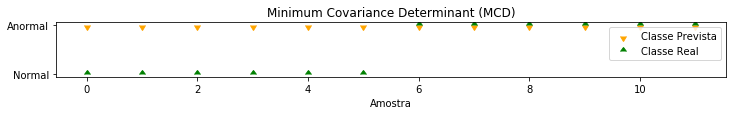

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1  1  1 -1 -1 -1 -1 -1]


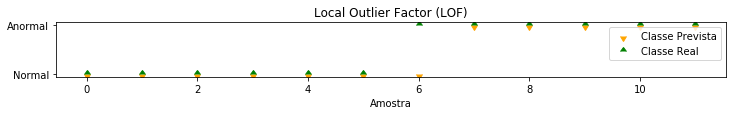

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


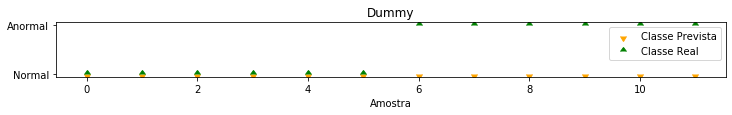

Instância 47: data\7\WELL-00006_20180618110721.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


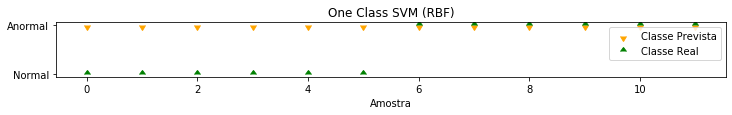

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[-1 -1  1 -1 -1 -1 -1 -1  1  1  1  1]


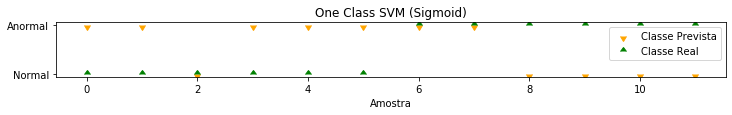

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[ 1  1 -1  1  1  1  1  1  1  1  1  1]


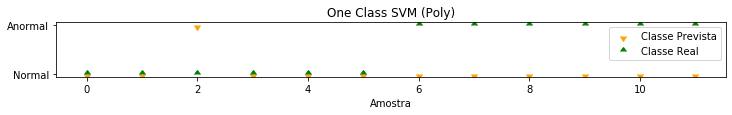

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[-1 -1 -1  1 -1 -1  1  1  1  1  1  1]


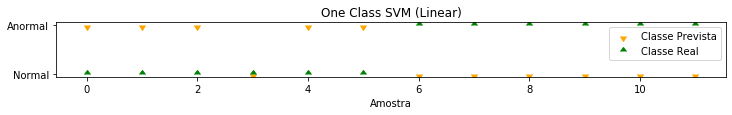

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1  1  1 -1 -1  1  1 -1  1 -1  1 -1]


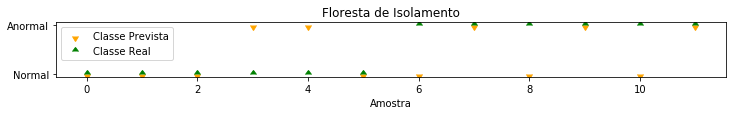

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


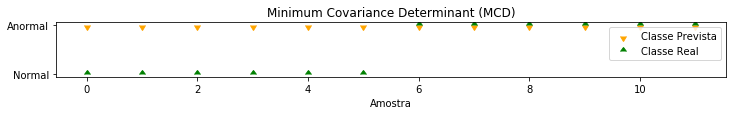

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1  1  1 -1 -1 -1 -1 -1]


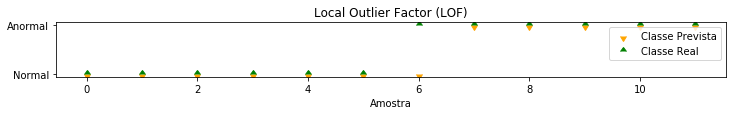

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


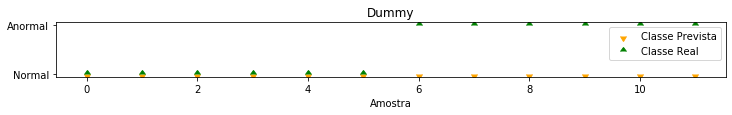

Instância 48: data\7\WELL-00006_20180620181348.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


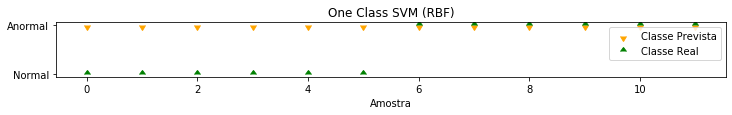

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[-1 -1  1  1  1  1  1 -1 -1 -1 -1 -1]


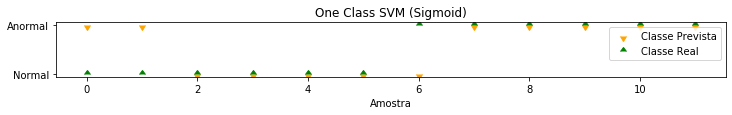

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[ 1  1  1  1  1  1  1  1 -1 -1  1  1]


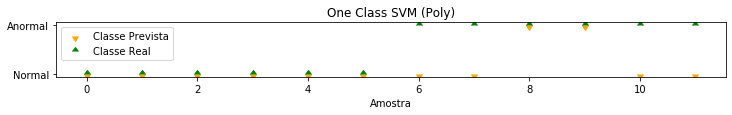

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[ 1  1  1  1  1 -1  1 -1 -1 -1 -1 -1]


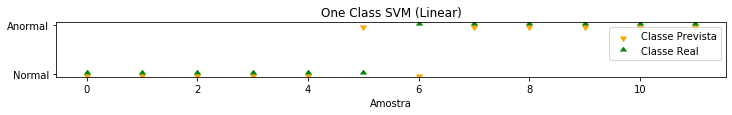

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1  1  1  1  1  1  1 -1 -1 -1 -1 -1]


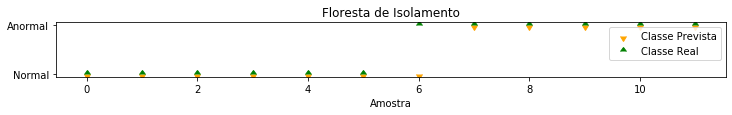

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


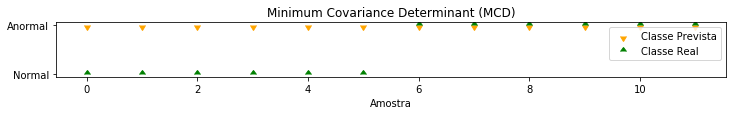

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1  1  1 -1 -1 -1 -1 -1]


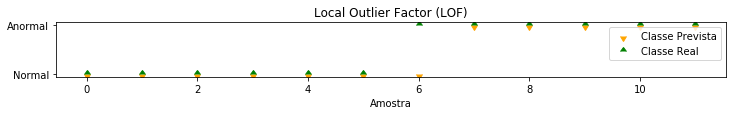

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


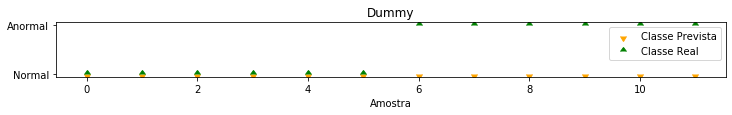

Instância 49: data\7\WELL-00018_20180611040207.csv
	ignorado porque normal_period_size é insuficiente para treinamento (0)

Instância 50: data\8\WELL-00019_20170301182317.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


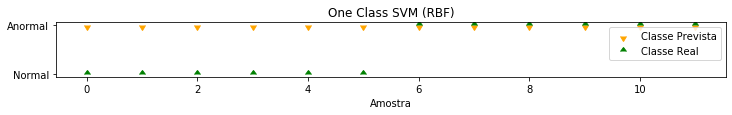

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[ 1 -1 -1  1 -1  1  1 -1 -1 -1 -1 -1]


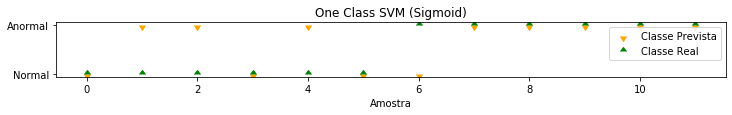

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[ 1 -1  1  1 -1  1  1 -1 -1 -1 -1 -1]


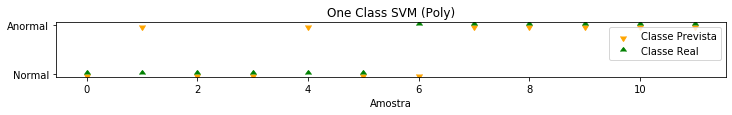

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[ 1 -1 -1  1 -1  1  1 -1 -1 -1 -1 -1]


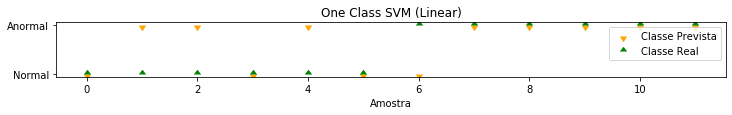

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[-1 -1  1  1  1  1  1  1  1  1  1  1]


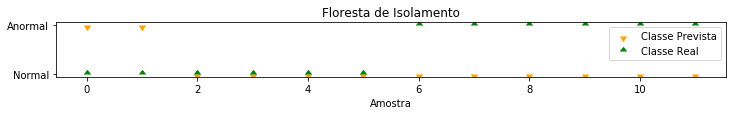

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


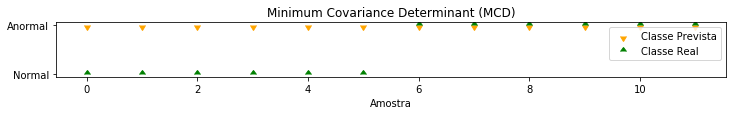

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1]


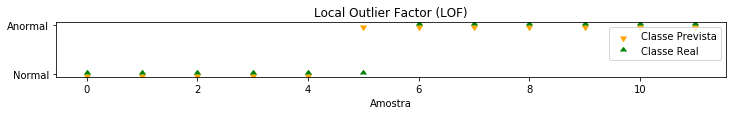

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


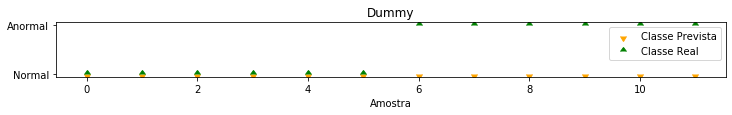

Instância 51: data\8\WELL-00020_20120410192326.csv
	ignorado porque normal_period_size é insuficiente para treinamento (173)

Instância 52: data\8\WELL-00021_20170509013517.csv
y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (RBF)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


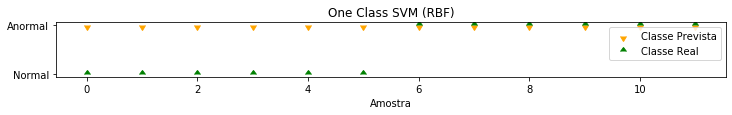

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Sigmoid)
[-1  1  1  1  1  1  1  1 -1 -1 -1 -1]


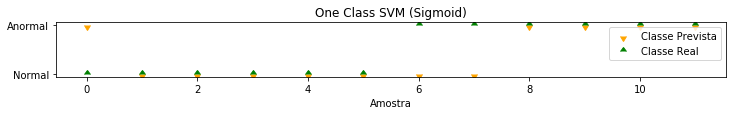

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Poly)
[ 1 -1 -1  1  1  1  1  1  1 -1 -1 -1]


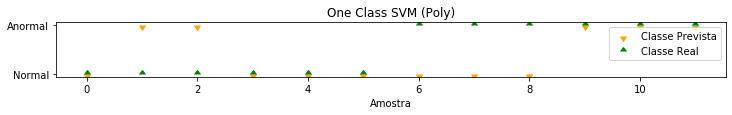

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - One Class SVM (Linear)
[-1 -1 -1  1  1  1  1  1  1  1 -1 -1]


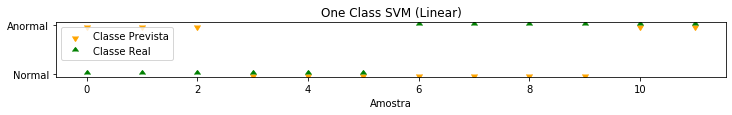

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Floresta de Isolamento
[ 1  1  1  1  1 -1 -1 -1  1 -1 -1 -1]


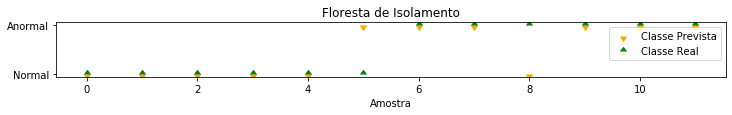

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Minimum Covariance Determinant (MCD)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


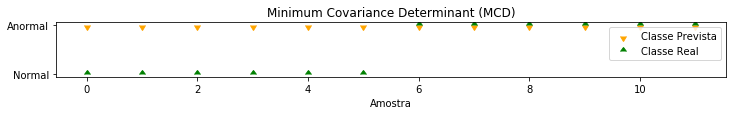

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Local Outlier Factor (LOF)
[ 1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


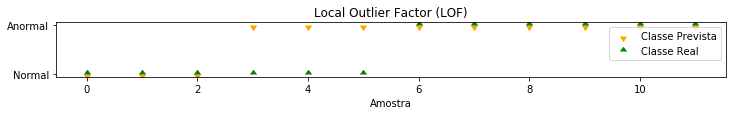

y_train
[1 1 1 1 1 1 1 1 1]
y_test
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
y_pred - Dummy
[1 1 1 1 1 1 1 1 1 1 1 1]


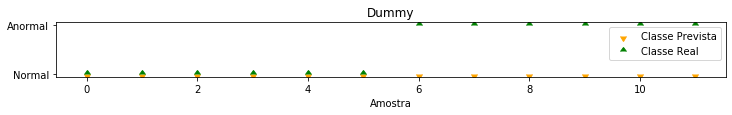

In [11]:
# For each real instance with any type of undesirable event
scores = pd.DataFrame()
ignored_instances = 0
used_instances = 0
for i, row in real_instances.iterrows():
    # Loads the current instance
    class_code, instance_path = row
    print(f'Instância {i+1}: {instance_path}')
    df = load_instance(instance_path)
    
    # Ignores instances without sufficient normal periods
    normal_period_size = (df['class']==float(normal_class_code)).sum()
    if normal_period_size < min_normal_period_size:
        ignored_instances += 1
        print(f'\tignorado porque normal_period_size é insuficiente para treinamento ({normal_period_size})\n')
        continue
    used_instances += 1
        
    # Extracts samples from the current real instance
    ret = extract_samples(df, class_code)
    df_samples_train, y_train, df_samples_test, y_test = ret

    # Changes types of the labels (tsfresh's requirement)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    # (Wander) incluidas as duas linhas abaixo para ajustar y_train também (?)
    y_train[y_train!=normal_class_code] = -1
    y_train[y_train==normal_class_code] = 1

    # We want binary classification: 1 for inliers (negative class = normal instance) and
    # -1 for outliers (positive class = instance with anomaly) (sklearn's requirement)
    y_test[y_test!=normal_class_code] = -1
    y_test[y_test==normal_class_code] = 1
    
    # Drops the bad vars
    good_vars = np.isnan(df_samples_train[vars]).mean(0) <= max_nan_percent
    std_vars = np.nanstd(df_samples_train[vars], 0)
    good_vars &= (std_vars > std_vars_min)    
    good_vars = list(good_vars.index[good_vars])
    bad_vars = list(set(vars)-set(good_vars))
    df_samples_train.drop(columns=bad_vars, inplace=True, errors='ignore')
    df_samples_test.drop(columns=bad_vars, inplace=True, errors='ignore')
    
    # Normalizes the samples (zero mean and unit variance)
    scaler = preprocessing.StandardScaler()
    df_samples_train[good_vars] = scaler.fit_transform(df_samples_train[good_vars]).astype('float32')
    df_samples_test[good_vars] = scaler.transform(df_samples_test[good_vars]).astype('float32')
    
    # Extracts features from samples
    X_train = extract_features(df_samples_train, 
                               column_id='id', 
                               column_sort='timestamp', 
                               default_fc_parameters=df_fc_p,
                               impute_function=impute,
                               n_jobs=0,
                               disable_progressbar=disable_progressbar)
    X_train = X_train.reset_index(drop=True)
    X_test = extract_features(df_samples_test, 
                              column_id='id', 
                              column_sort='timestamp',
                              default_fc_parameters=df_fc_p,
                              impute_function=impute,
                              n_jobs=0,
                              disable_progressbar=disable_progressbar)
    X_test = X_test.reset_index(drop=True)

    # Lista de classificadores a serem utilizados em cada instância real
    gamma='scale'
    nu = 0.5
    n_jobs=None

    clfs = {'One Class SVM (RBF)':     OneClassSVM(kernel='rbf', gamma=gamma, nu=nu),
            'One Class SVM (Sigmoid)': OneClassSVM(kernel='sigmoid', gamma=gamma, nu=nu),
            'One Class SVM (Poly)':    OneClassSVM(kernel='poly', gamma=gamma, nu=nu),
            'One Class SVM (Linear)':  OneClassSVM(kernel='linear', gamma=gamma, nu=nu),
            'Floresta de Isolamento':        IsolationForest(n_jobs=n_jobs, behaviour='new',
                                                       contamination=0, random_state=random_state),
            'Minimum Covariance Determinant (MCD)': EllipticEnvelope(contamination=0),
            'Local Outlier Factor (LOF)': LocalOutlierFactor(novelty=True),
            'Dummy': DummyClassifier(strategy='constant', constant=1)
            }

    # Trains, tests and calculates the scores    
    scores = train_test_calc_scores(X_train, y_train, X_test, y_test, scores, clfs)

## 3. Resultados

Os resultados obtidos com os métodos implementados são apresentados abaixo.

In [12]:
print(f'Número de instâncias utilizadas: {used_instances}')
print(f'Número de instâncias ignoradas: {ignored_instances}')

Número de instâncias utilizadas: 36
Número de instâncias ignoradas: 16


In [13]:
print(f'Características utilizadas: {list(df_fc_p.keys())}')

Características utilizadas: ['median', 'mean', 'standard_deviation', 'variance', 'maximum', 'minimum']


Os comandos a seguir permitem salvar e recuperar os resultados de/para um arquivo CSV de forma conveniente.

In [14]:
scores.to_csv(r'./results/anomaly_detection_scores.csv')
#scores = pd.read_csv(r'./results/anomaly_detection_scores.csv', index_col=0)

### 3.1. Métricas em formato tabular

As tabelas a seguir apresentam as médias e o desvio padrão das métricas, respectivamente. Ambos são ordenados pela medida-F1.

In [15]:
# Médias
mean_score_table = scores.groupby('CLASSIFICADOR').mean().sort_values(by=['F1'], ascending=False)
mean_score_table

,F1,PRECISAO,REVOGACAO,TESTE [s],TREINAMENTO [s]
CLASSIFICADOR,,,,,
Local Outlier Factor (LOF),0.872685,0.872685,0.872685,0.000915,0.000804
Floresta de Isolamento,0.719907,0.719907,0.719907,0.030968,0.116592
One Class SVM (RBF),0.537037,0.537037,0.537037,0.000607,0.000718
Minimum Covariance Determinant (MCD),0.525463,0.525463,0.525463,0.001021,0.020465
Dummy,0.500000,0.500000,0.500000,0.000138,0.000275
One Class SVM (Poly),0.472222,0.472222,0.472222,0.000466,0.000835
One Class SVM (Sigmoid),0.469907,0.469907,0.469907,0.000582,0.000693
One Class SVM (Linear),0.414352,0.414352,0.414352,0.000668,0.000720


In [16]:
# Desvios Padrão
std_score_table = scores.groupby('CLASSIFICADOR').std().sort_values(by=['F1'], ascending=True)
std_score_table

,F1,PRECISAO,REVOGACAO,TESTE [s],TREINAMENTO [s]
CLASSIFICADOR,,,,,
Dummy,0.000000,0.000000,0.000000,0.000350,0.000449
One Class SVM (RBF),0.085552,0.085552,0.085552,0.000491,0.000514
Minimum Covariance Determinant (MCD),0.088684,0.088684,0.088684,0.000167,0.005732
Local Outlier Factor (LOF),0.137272,0.137272,0.137272,0.000498,0.000401
Floresta de Isolamento,0.177228,0.177228,0.177228,0.001304,0.002914
One Class SVM (Sigmoid),0.187033,0.187033,0.187033,0.000499,0.000466
One Class SVM (Poly),0.187929,0.187929,0.187929,0.000500,0.000379
One Class SVM (Linear),0.194657,0.194657,0.194657,0.000535,0.000453


### 3.2. Análise comparativa múltipla não paramétrica

A saída a seguir (p_value <5%) revela que a hipótese nula de que todos os classificadores têm o mesmo desempenho é falsa. Isso significa que pelo menos um deles tem, com alta probabilidade, diferentes valores médios de medida-F1 em comparação com os outros.

In [17]:
clfs_names = list(clfs.keys())
f1s = [scores.loc[scores['CLASSIFICADOR']==cn, 'F1'].values for cn in clfs_names]
f_value_stat, p_value, ranks, pivots = stac.friedman_test(*(f1s))
print(f'p_value: {p_value}')

p_value: 1.1102230246251565e-16


Agora investigamos quais classificadores têm valores médios de medida-F1 estatisticamente diferentes em comparação com o classificador Dummy (sempre prediz a classe majoritária = normal). Os p_values e adj_p_values indicam que "Floresta de Isolamento" é a única com desempenho estatisticamente melhor, com alta probabilidade, em comparação com o classificador Dummy (<5%).

In [18]:
ret = stac.holm_test(len(pivots), pivots, clfs_names, clfs_names.index('Dummy'))
comp, z_values_stat, p_values, adj_p_values = ret
for i in range(len(comp)):
    print(f'{comp[i]}: \n\tp_values: {p_values[i]}\n\tadj_p_values: {adj_p_values[i]}')

Dummy vs Local Outlier Factor (LOF): 
	p_values: 1.1402701005636118e-10
	adj_p_values: 7.981890703945282e-10
Dummy vs Floresta de Isolamento: 
	p_values: 1.6617992056211506e-05
	adj_p_values: 9.970795233726903e-05
Dummy vs One Class SVM (Linear): 
	p_values: 0.09693818842839907
	adj_p_values: 0.4846909421419954
Dummy vs One Class SVM (RBF): 
	p_values: 0.5160029354435864
	adj_p_values: 1
Dummy vs Minimum Covariance Determinant (MCD): 
	p_values: 0.6825716280432048
	adj_p_values: 1
Dummy vs One Class SVM (Sigmoid): 
	p_values: 0.7003113729368906
	adj_p_values: 1
Dummy vs One Class SVM (Poly): 
	p_values: 0.7362769783410712
	adj_p_values: 1


### 3.3. Metricas em Boxplots

Os boxplots apresentados abaixo são ordenados pelos valores médios de medida-F1 dos classificadores considerados.

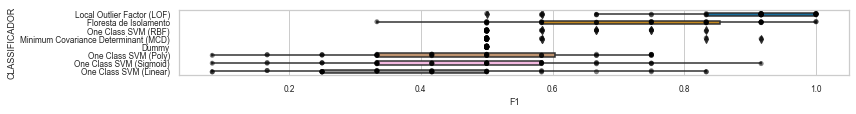

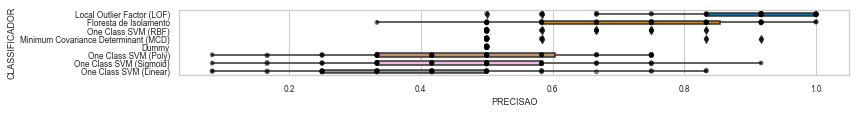

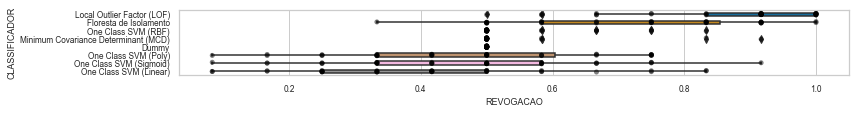

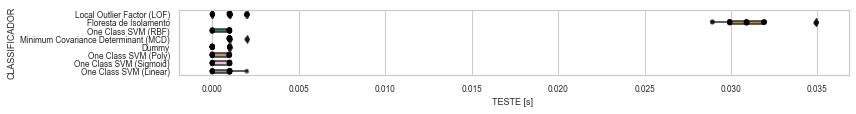

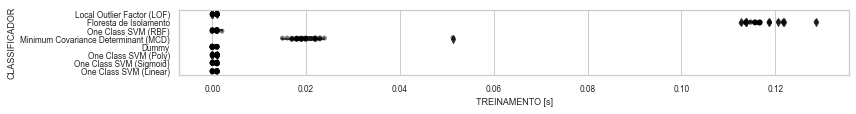

In [19]:
sns.set(font_scale=0.75, style="whitegrid")
for score in scores.columns.drop(['CLASSIFICADOR']):
    plt.figure(figsize=(12,1.2))
    bplot=sns.boxplot(y='CLASSIFICADOR', x=score, data=scores, width=0.4, 
                      palette='colorblind', order=list(mean_score_table.index));
    bplot=sns.stripplot(y='CLASSIFICADOR', x=score, data=scores, jitter=True, marker='o', 
                        alpha=0.5, color='black', order=list(mean_score_table.index))

## 4. Conclusão

Tendo em vista os resultados apresentados acima, podemos afirmar que o classificador "XXX" apresenta o melhor desempenho em termos de médias das métricas medida-F1, precisão e revogação, mas não em termos do desvio padrão dessas métricas nem dos tempos de treinamento e teste.

Após uma análise comparativa múltipla não paramétrica, verificamos que o classificador "XXX" produz um valor médio de medida-F1 estatisticamente diferente em comparação ao classificador Dummy.

In [20]:
# Calcular tempo total do notebook Jupyter
print(f'Tempo total de execução (hh:mm:ss.ms): {datetime.now() - start_time}')

Tempo total de execução (hh:mm:ss.ms): 0:00:42.497006
